In [235]:
import torch 
import torch.nn as nn 
import torch.optim as optim  
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt 
import os 
import torch.nn.functional as F
import random 
from datetime import datetime
import json
from math import comb, pow, log2
from torch.distributions import Binomial

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
# The quantity of steps in the diffusion process
T = 100
# Quantity of samples to use when approximating the loss
num_sample_steps = 10
#training:
# Quantity of training epochs
epochs = 100
# Learning rate
lr = 0.01
# How frequently to checkpoint the model
save_every_n_epochs = 1
# The quantity of examples to print during training
num_examples = 50
# The threshold for grad_clip_norm
clip_thresh = 1.0
sequence_length = 784
# Quantity of training samples per minibatch
batch_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print()

digit = 5

model_path = f"model_{digit}.pth"

# Ensure checkpoints directory exists before loading
result_dir = "All_Digits.dir"
checkpoint_dir = os.path.join(result_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

latest_model_path = os.path.join(checkpoint_dir, model_path)


Device: cpu



In [236]:
num_training_img = 20

early_ts = range(0, 11)
middle_ts = range(T//2 - 5, T//2 + 6)
late_ts = range(T - 10, T + 1)

selected_ts = sorted(set(early_ts) | set(middle_ts) | set(late_ts))

train_loss_tracking = {t: [] for t in selected_ts}
val_loss_tracking = {t: [] for t in selected_ts}


def loss_tracking():
    train_loss= {t: [] for t in selected_ts}
    val_loss= {t: [] for t in selected_ts}
    return train_loss, val_loss

def get_group(t):
    if t in early_ts:
        return 'early'
    elif t in middle_ts:
        return 'middle'
    elif t in late_ts:
        return 'late'
    else:
        return None
group_colors = {
    'early': 'blue',
    'middle': 'green',
    'late': 'red'
}

In [237]:
#kl_divergence, entropy
eps = 1e-30

def kl_div(q, p):
    '''KL Divergence of two multivariate Bernoulli distributions'''
    q = torch.clip(q, min=1e-10, max=1-(1e-7))
    p = torch.clip(p, min=1e-10, max=1-(1e-7))
    return torch.sum((q * torch.log2((q/p) + eps)) + ((1.0-q) * torch.log2(((1.0-q)/(1.0-p)) + eps)), dim=1)


def entropy_of_q_conditional(sequence_length, beta_tilde_t):
    total_entropy = 0.0
    for k in range(0, sequence_length+1):
        n_choose_k = comb(sequence_length, k)
        prob = pow((1.0-(0.5*beta_tilde_t)), k) * pow(0.5*beta_tilde_t, sequence_length-k)
        cur_entropy = n_choose_k * prob * log2(prob + eps)
        total_entropy += cur_entropy
    return -1.0 * total_entropy


def entropy_of_prior(sequence_length):
    '''Assuming all Bernoulli distributions in prior have prob 0.5.
    Fun fact: this basically just returns float(sequence_length)'''
    total_entropy = 0.0
    for k in range(0, sequence_length+1):
        n_choose_k = comb(sequence_length, k)
        prob = pow((1.0-0.5), k) * pow(0.5, sequence_length-k)
        cur_entropy = n_choose_k * prob * log2(prob + eps)
        total_entropy += cur_entropy
    return -1.0 * total_entropy

In [238]:
#generating digits

class ReverseModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.shared_layers = torch.nn.Sequential(
            torch.nn.Linear(sequence_length, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 50),
            torch.nn.ReLU()
        )

        #stores list of layers, one for each timestep t from 1 to T
        self.output_layers = nn.ModuleList([torch.nn.Linear(50, sequence_length) for x in range(T)])
        self.output_sigmoid = torch.nn.Sigmoid()

    def forward(self, x, t):
        x = self.shared_layers(x)
        x = self.output_layers[t-1](x)
        x = self.output_sigmoid(x)
        return x
    
# class UNetBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         return self.block(x)

# class ReverseUNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.time_embed = nn.Embedding(T + 1, 32)

#         # Encoder
#         self.enc1 = UNetBlock(1, 32)
#         self.pool1 = nn.MaxPool2d(2)
#         self.enc2 = UNetBlock(32, 64)
#         self.pool2 = nn.MaxPool2d(2)

#         # Bottleneck
#         self.bottleneck = UNetBlock(64 + 32, 128)  # includes time embedding

#         # Decoder
#         self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.dec1 = UNetBlock(64 + 64, 64)
#         self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
#         self.dec2 = UNetBlock(32 + 32, 32)

#         # Output
#         self.output = nn.Conv2d(32, 1, kernel_size=1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x, t):
#         t_embed = self.time_embed(torch.tensor([t], device=x.device)).view(1, -1, 1, 1)
#         t_embed = t_embed.expand(x.shape[0], -1, x.shape[2] // 4, x.shape[3] // 4)  # match bottleneck size

#         # Encoder
#         x1 = self.enc1(x)
#         x2 = self.enc2(self.pool1(x1))

#         # Bottleneck + time embedding
#         bottleneck_input = self.pool2(x2)
#         bottleneck = self.bottleneck(torch.cat([bottleneck_input, t_embed], dim=1))

#         # Decoder
#         x = self.dec1(torch.cat([self.up1(bottleneck), x2], dim=1))
#         x = self.dec2(torch.cat([self.up2(x), x1], dim=1))

#         return self.sigmoid(self.output(x)).view(x.shape[0], -1)

In [239]:
def plot_loss(epochs, losses, save_dir, filename='loss_curve.png'):
    '''Given losses and epoch labels, this creates a nice plot.'''
    plt.plot(epochs, losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(os.path.join(save_dir, filename))
    plt.clf()

In [240]:

def binarize_image(x):
    return torch.bernoulli(x)

def get_train_data(digit=digit):
    transform = transforms.Compose([
        transforms.ToTensor(),
        binarize_image
    ])

    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    digit_indices = [i for i, label in enumerate(dataset.targets) if label == digit]

    random.shuffle(digit_indices)

    # Use only the first 10 examples
    train_indices = digit_indices[:num_training_img]
    val_indices = digit_indices[num_training_img:2*num_training_img]

    small_train = Subset(dataset, train_indices)
    small_val = Subset(dataset, val_indices)
    
    train_loader = DataLoader(small_train, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(small_val, batch_size = batch_size, shuffle=False)

    return train_loader, val_loader

def get_test_data(digit=digit):
    transform = transforms.Compose([
        transforms.ToTensor(),
        binarize_image
    ])
    dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    digit_indices = [i for i, label in enumerate(dataset.targets) if label == digit]
    test_subset = Subset(dataset, digit_indices)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return test_loader

def show_training_images(train_loader):
    images_collected = []

    for images, _ in train_loader:
        for img in images:
            images_collected.append(img)

    rows = int(num_training_img ** 0.5)
    cols = int((num_training_img + rows - 1) // rows)  # ensures enough columns

    plt.figure(figsize=(cols, rows))
    for i in range(len(images_collected)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images_collected[i][0], cmap='gray')
        plt.axis("off")
    plt.suptitle("Sample Training Images")
    plt.tight_layout()

    path = os.path.join(result_dir, f'results_{digit}')

    os.makedirs(path, exist_ok=True)  # Make sure directory exists
    save_path = os.path.join(path, f"train_img_{digit}.png")
    plt.savefig(save_path)

    plt.show()
    plt.close()

In [ ]:
class BernoulliDiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = ReverseModel()
    

        # calculate the array of beta_tilde_t values from t=1 to t=T
        self.beta_tilde_t = [torch.zeros((sequence_length)).to(device)]
        for cur_t in range(1, T+1):
            self.beta_tilde_t.append((self.beta_tilde_t[cur_t-1] + self.beta_t(cur_t) - (self.beta_t(cur_t)*self.beta_tilde_t[cur_t-1])))
        self.beta_tilde_t = torch.stack(self.beta_tilde_t)

        self.H_start = entropy_of_q_conditional(sequence_length, self.beta_tilde_t[1,0].item())
        self.H_end = entropy_of_q_conditional(sequence_length, self.beta_tilde_t[T, 0].item())
        self.H_prior = entropy_of_prior(sequence_length)
    
    def p_conditional_prob(self, x_t, t):
        '''Returns the probabilities of the Bernoulli variables for the reverse process from t to t-1,
        i.e. p(x_(t-1)|x_t)'''
        return self.model(x_t, t)

    @torch.no_grad()
    def p_step(self, x, t):
        '''Performs reverse process on x from t to t-1'''
        return torch.bernoulli(self.model(x, t))

    @torch.no_grad()
    def p_sample(self, batch_size, x=None):
        '''Performs complete reverse process on a batch of noise'''
        if x is None:
            init_prob = torch.empty((batch_size, sequence_length)).fill_(0.5).to(device)
            x = torch.bernoulli(init_prob) 
        else:
            assert batch_size == x.size(dim=0)

        for cur_t in range(T, 0, -1):
            x = torch.bernoulli(self.p_conditional_prob(x, cur_t))
        return x

    def beta_t(self, t):
        '''The bit flip probability at step t of the forward process'''
        return 1.0/(T-t+1)

    def q_conditional_prob(self, x_t, t):
        '''Returns the probabilities of the Bernoulli variables for the forward process
        with x_t as input while going from t to t+1, i.e. q(x_(t+1)|x_t)'''
        # had to change the beta_t equation here to keep indexing consistent
        return (x_t * (1.0 - self.beta_t(t+1))) + 0.5 * self.beta_t(t+1)

    def q_conditional_prob_wrt_x_0(self, x_0, t):
        '''Returns the probabilities of the Bernoulli variables for observing samples of x_t
        given 
        
        , i.e. q(x_t|x_0)'''

        #print(f"x_0.size(): {x_0.size()}", flush = True)

        beta_tilde_t = self.beta_tilde_t[t].expand(x_0.size())
        return ((x_0 * (1.0 - beta_tilde_t)) + 0.5 * beta_tilde_t)

    @torch.no_grad()
    def q_step(self, x, t):
        '''Performs forward process on x from t to t+1'''
        probs = self.q_conditional_prob(x, t)
        return torch.bernoulli(probs)

    def q_sample(self, x_0, t):
        '''Returns a sample x_t given input x_0'''
        return torch.bernoulli(self.q_conditional_prob_wrt_x_0(x_0, t))
    
    def forward(self, x_0, loss_tracking):
        '''Approximates the loss via equation 13 in Deep Unsupervised Learning using Nonequilibrium Thermodynamics
        using samples from the reverse process.'''
        # the monte carlo sampling is performed using the minibatch
        total_loss = torch.zeros((x_0.size(dim=0),)).to(device)
        for t in range(1, T + 1):
            x_t = self.q_sample(x_0, t)
            beta_t = self.beta_t(t)
            posterior = x_0*(1-self.beta_tilde_t[t-1]) + 0.5*self.beta_tilde_t[t-1]
            posterior *= x_t * (1-0.5*beta_t) + (1 - x_t) * (0.5*beta_t)
            normalizing_constant = x_t * self.q_conditional_prob_wrt_x_0(x_0, t) + (1-x_t) * (1-self.q_conditional_prob_wrt_x_0(x_0, t))
            posterior = posterior / normalizing_constant
            kl_divergence = kl_div(posterior,
                                   self.p_conditional_prob(x_t, t))
            curr_loss = kl_divergence + self.H_start - self.H_end + self.H_prior
            total_loss += curr_loss
            if t in loss_tracking:
                mean_loss = curr_loss.mean().item()
                mean_loss /= sequence_length
                loss_tracking[t].append(mean_loss)
                #print(f"Step t={t}: mean normalized loss = {mean_loss:.4f}")
        return torch.mean(total_loss)

In [ ]:
class Trainer:
    '''Given a diffusion model and config file, this class
    trains the model from scratch and then saves the result.'''

    def __init__(self, diffusion_model, data_loader, val_loader):
        self.diffusion_model = diffusion_model
        self.data_loader = data_loader
        self.val_loader = val_loader

        self.optimizer = optim.AdamW(diffusion_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        self.initialize_output_dir_()
        self.initialize_new_training_()

    def initialize_output_dir_(self):
        '''Creates the file where results of training will be stored'''
        self.working_dir = result_dir
        
        all_results_dir = os.path.join(self.working_dir, f'results_{digit}')

        os.makedirs(all_results_dir, exist_ok=True)  # Creates 'results/' if it doesn't exist

        self.result_dir = all_results_dir
        
    def generate_random_data(self):
        '''Generates a random tensor with the same shape as training data.
        Used for initialization'''
        m = Binomial(1, torch.zeros((batch_size, sequence_length)).fill_(0.5))
        return m.sample().to(device)

    def initialize_new_training_(self):
        # Zero grad, input a random tensor, then backprop
        self.diffusion_model.zero_grad()
        input = self.generate_random_data()
        out = self.diffusion_model(input, train_loss_tracking)
        out.backward()

        # reset all metrics of training
        self.losses = []
        self.examples_per_epoch = []
        self.val_losses = []

    def train_step_(self):
        '''Actual training occurs here'''
        avg_loss = 0.0
        batch_count = 0
        for batch_idx, (x_0, _) in enumerate(self.data_loader):
            x_0 = x_0.view(x_0.size(0), -1)  # Reshape to (batch_size, sequence_length)
            x_0 = x_0.to(device)
            self.optimizer.zero_grad()
            output = self.diffusion_model(x_0, train_loss_tracking)
            #print(f"output size: {output.item()}")
            
            if torch.isnan(output).any():
                raise Exception('Loss is NaN. Is your learning rate too high?')
            
            output.backward() #Computs gradients with back propogation
            torch.nn.utils.clip_grad_norm_(self.diffusion_model.parameters(), clip_thresh)
            self.optimizer.step() #Update model parameters
            #batch = self.data_loader.next_minibatch()
            batch_count += 1
            avg_loss += output.detach()
            
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}, Loss: {((avg_loss.mean())/batch_count):.4f}")
                
        avg_loss = avg_loss / batch_count
        self.losses.append(avg_loss.item())
        return avg_loss


    def print_training_info_(self):
        print('Epoch: {}: Loss: {}'.format(self.epoch+1, self.losses[-1]))
    
    import matplotlib.pyplot as plt

    def make_plots_(self):
        epochs_plotted = list(range(len(self.losses)))

        plt.figure(figsize=(10, 6))
        plt.plot(epochs_plotted, self.losses, label='Training Loss', marker='o')
        plt.plot(epochs_plotted, self.val_losses, label='Validation Loss', marker='x')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)

        for i in range(len(self.losses)):
            self.losses[i] = self.losses[i]/(sequence_length*T)
            self.val_losses[i] = self.val_losses[i]/(sequence_length*T)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs_plotted, self.losses, label= f'Training Loss {digit}', marker='o')
        plt.plot(epochs_plotted, self.val_losses, label= f'Validation Loss {digit}', marker='x')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss Over Time {digit}')
        plt.legend()
        plt.grid(True)


        plot_path = os.path.join(self.result_dir, f'loss_{digit}.png')
        plt.savefig(plot_path)

        plt.figure(figsize=(8, 5))


        plt.figure(figsize=(10, 6))

        # Plot validation loss
        for t in selected_ts:
            group = get_group(t)
            if group and t in val_loss_tracking:
                losses = val_loss_tracking[t]
                plt.plot(
                    range(len(losses)),
                    losses,
                    label=f"Val t = {t}",
                    linestyle='--',
                    color=group_colors[group]
                )

        # Plot training loss
        for t in selected_ts:
            group = get_group(t)
            if group and t in train_loss_tracking:
                losses = train_loss_tracking[t]
                plt.plot(
                    range(len(losses)),
                    losses,
                    label=f"Train t = {t}",
                    linestyle='-',
                    color=group_colors[group]
                )

        plt.xlabel("Batches")
        plt.ylabel("Loss")
        plt.title(f"Per-Timestep Training and Validation Loss {digit}")
        plt.legend(title="Type and Timestep", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        
        timestep_plot_path = os.path.join(self.result_dir, f'timestep_loss_{digit}.png')
        plt.savefig(timestep_plot_path)

        plt.show()
        plt.close()


    def validate_step_(self, val_loader):
        self.diffusion_model.eval()
        val_loss = 0.0
        count = 0
        with torch.no_grad():
            for x_val, _ in val_loader:
                x_val = x_val.view(x_val.size(0), -1).to(device)
                loss = self.diffusion_model(x_val, val_loss_tracking)
                val_loss += loss.item()
                count += 1
        self.diffusion_model.train()
        avg_val_loss = val_loss / count
        self.val_losses.append(avg_val_loss)
        return avg_val_loss


    def train(self):
        for self.epoch in range(0, epochs):
            print(f"Epoch: {self.epoch+1}")
            print()
            self.train_step_()

            val_loss = self.validate_step_(self.val_loader)
            print(f"Validation Loss: {val_loss:.4f}")

            print()
            print()
            self.print_training_info_()
            print()
            print()
                
        torch.save(self.diffusion_model.state_dict(), latest_model_path)

        self.make_plots_()

        return self.diffusion_model

No trained diffusion model for 0 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72252.5469
Validation Loss: 70801.0391


Epoch: 1: Loss: 72155.625


Epoch: 2

Batch 0, Loss: 70915.9531
Validation Loss: 66078.8711


Epoch: 2: Loss: 69861.7421875


Epoch: 3

Batch 0, Loss: 66357.1641
Validation Loss: 62072.5137


Epoch: 3: Loss: 65181.6328125


Epoch: 4

Batch 0, Loss: 61945.2422
Validation Loss: 60001.4785


Epoch: 4: Loss: 61229.5078125


Epoch: 5

Batch 0, Loss: 59772.9609
Validation Loss: 59955.4336


Epoch: 5: Loss: 59771.734375


Epoch: 6

Batch 0, Loss: 59287.7734
Validation Loss: 59658.1816


Epoch: 6: Loss: 59328.28125


Epoch: 7

Batch 0, Loss: 59096.6992
Validation Loss: 59015.8906


Epoch: 7: Loss: 59008.7734375


Epoch: 8

Batch 0, Loss: 58693.9297
Validation Loss: 58815.9785


Epoch: 8: Loss: 58769.46484375


Epoch: 9

Batch 0, Loss: 58936.8359
Validation Loss: 59038.3398


Epoch: 9: Loss: 58654.40234375


Epoch: 10

Batch 0, Loss: 58385.1445
Validation Loss: 5879

/var/folders/zz/8w5r4qqx3mx47rbgmhw0pvp00000gn/T/ipykernel_34128/1628243563.py:145: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


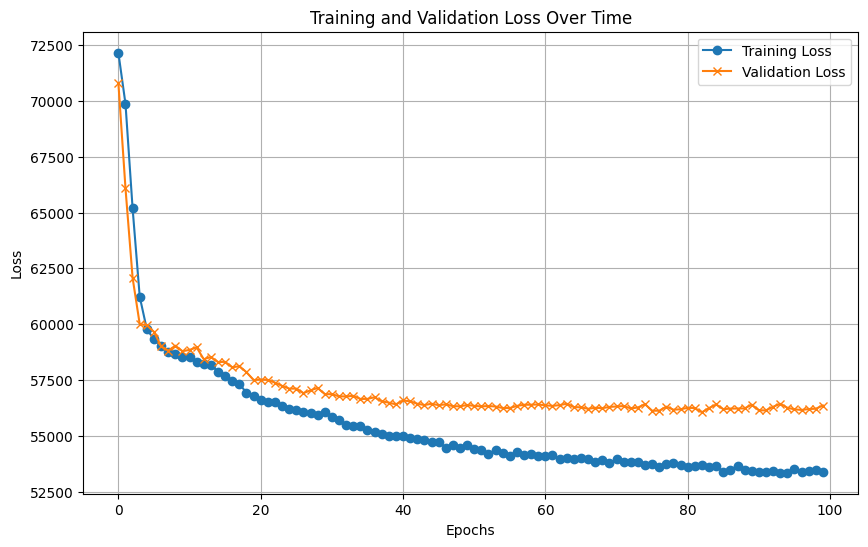

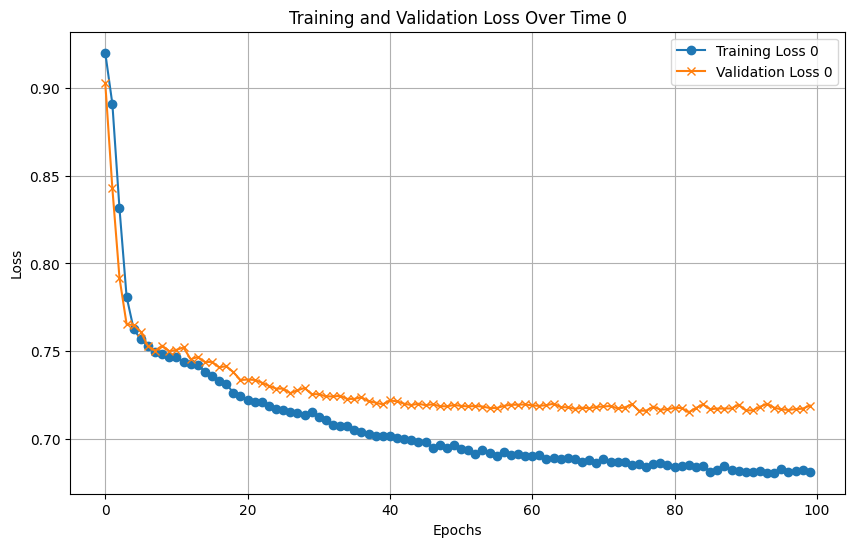

<Figure size 800x500 with 0 Axes>

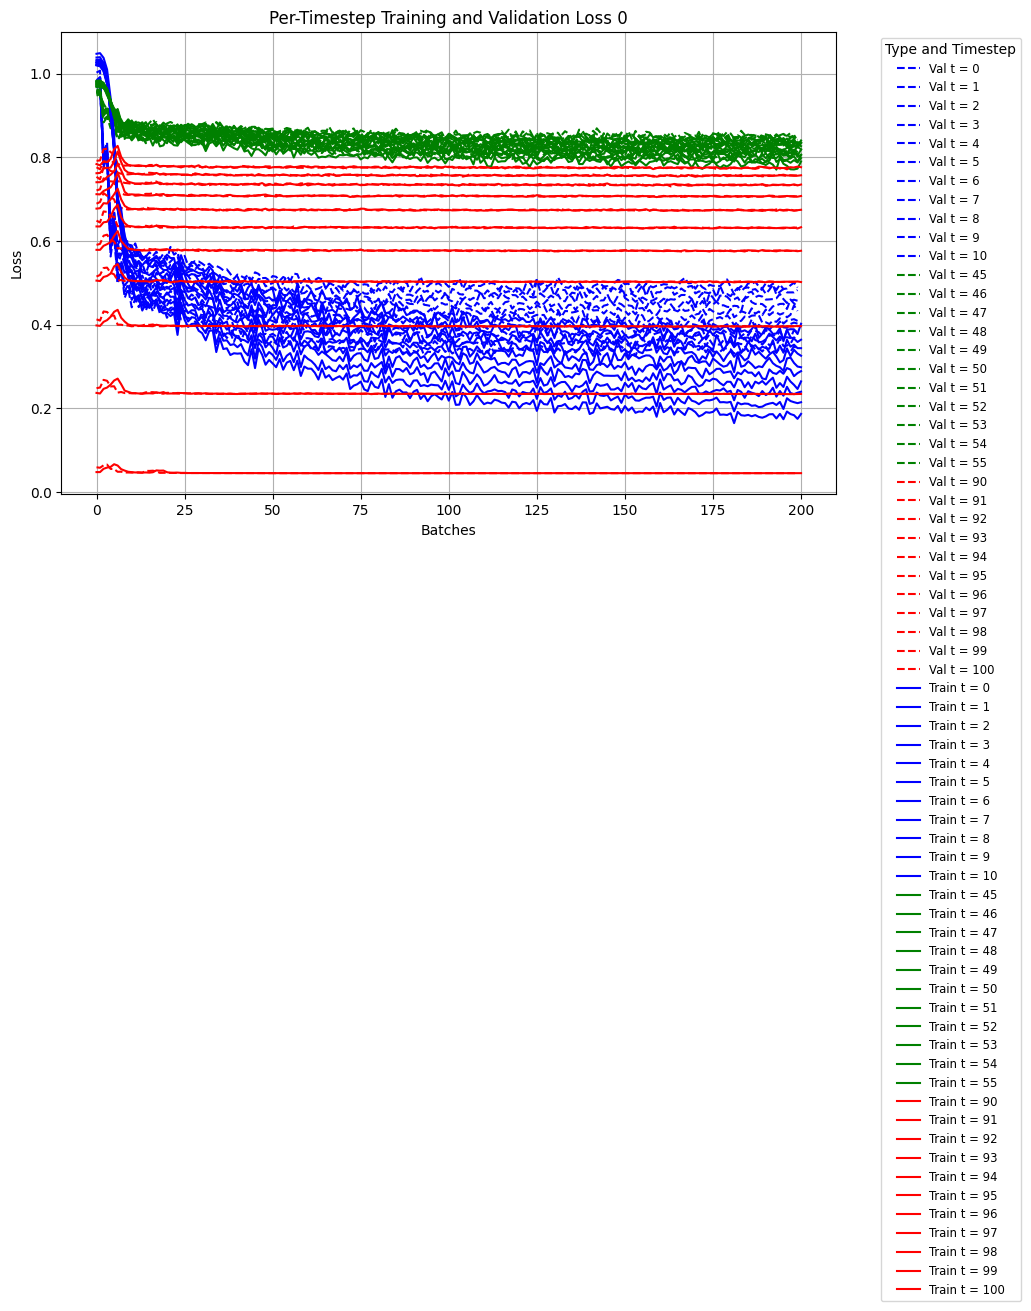

Generating a new digit...


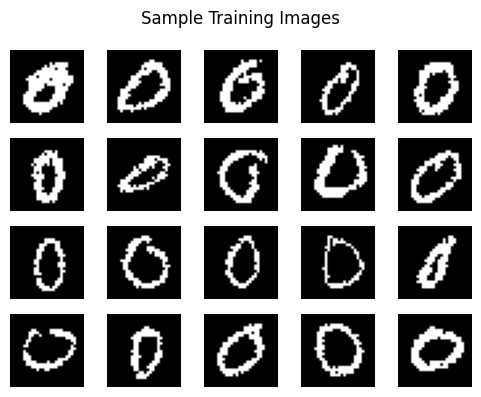

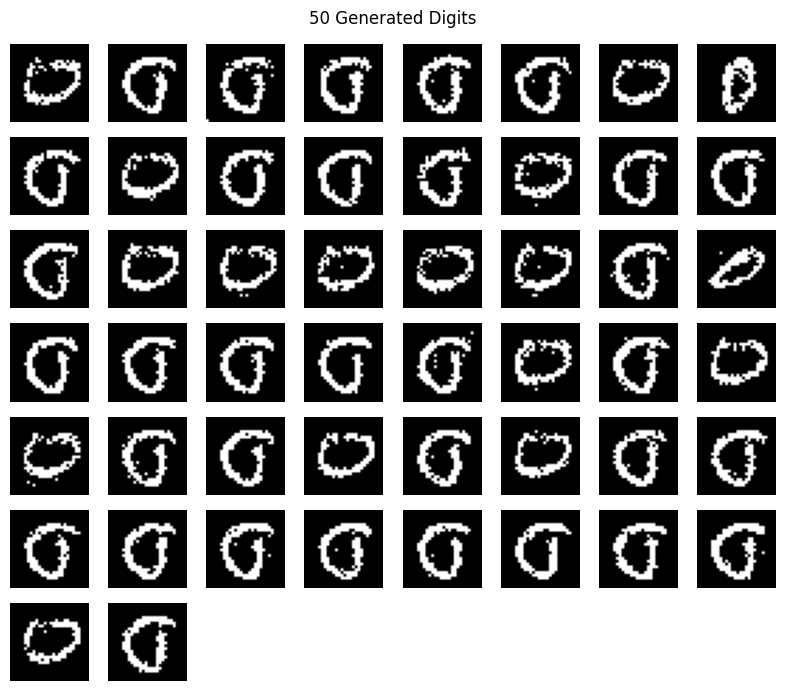

No trained diffusion model for 1 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72272.5547
Validation Loss: 70214.4180


Epoch: 1: Loss: 72028.546875


Epoch: 2

Batch 0, Loss: 70140.0469
Validation Loss: 64904.1445


Epoch: 2: Loss: 68879.265625


Epoch: 3

Batch 0, Loss: 65141.2617
Validation Loss: 58955.2969


Epoch: 3: Loss: 63052.5078125


Epoch: 4

Batch 0, Loss: 58611.9141
Validation Loss: 56120.8398


Epoch: 4: Loss: 57554.546875


Epoch: 5

Batch 0, Loss: 55308.2891
Validation Loss: 56025.0020


Epoch: 5: Loss: 55573.8125


Epoch: 6

Batch 0, Loss: 55889.7734
Validation Loss: 55750.1641


Epoch: 6: Loss: 55789.6953125


Epoch: 7

Batch 0, Loss: 55148.2617
Validation Loss: 55546.6309


Epoch: 7: Loss: 55323.265625


Epoch: 8

Batch 0, Loss: 55321.7734
Validation Loss: 55656.7422


Epoch: 8: Loss: 55259.1640625


Epoch: 9

Batch 0, Loss: 55071.8516
Validation Loss: 55695.0078


Epoch: 9: Loss: 55017.2734375


Epoch: 10

Batch 0, Loss: 54802.3125
Validation Loss: 55089.

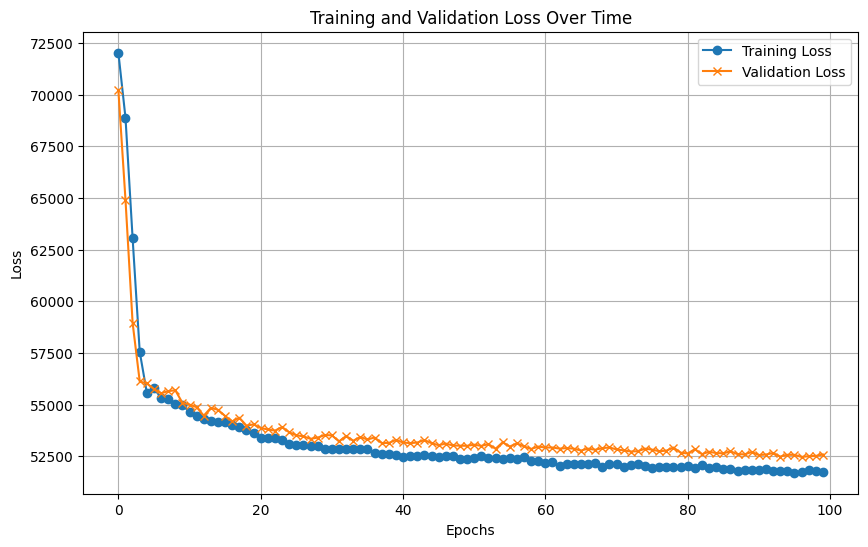

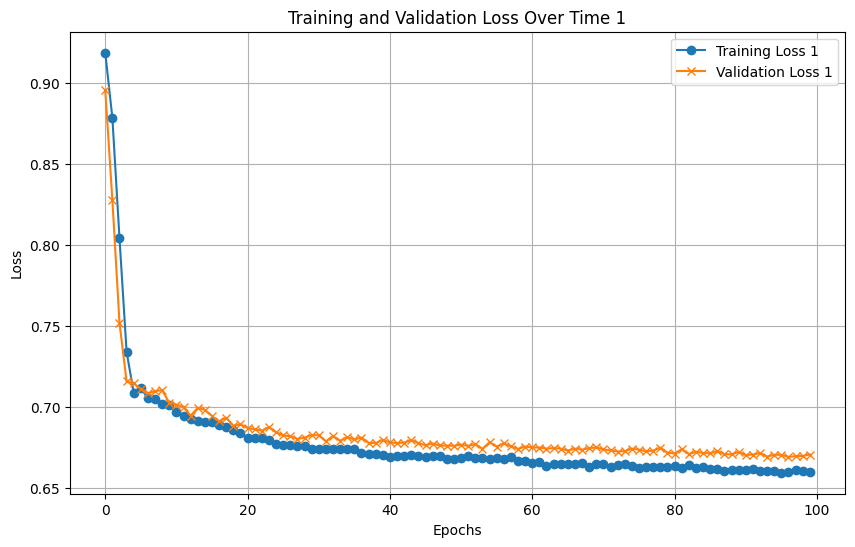

<Figure size 800x500 with 0 Axes>

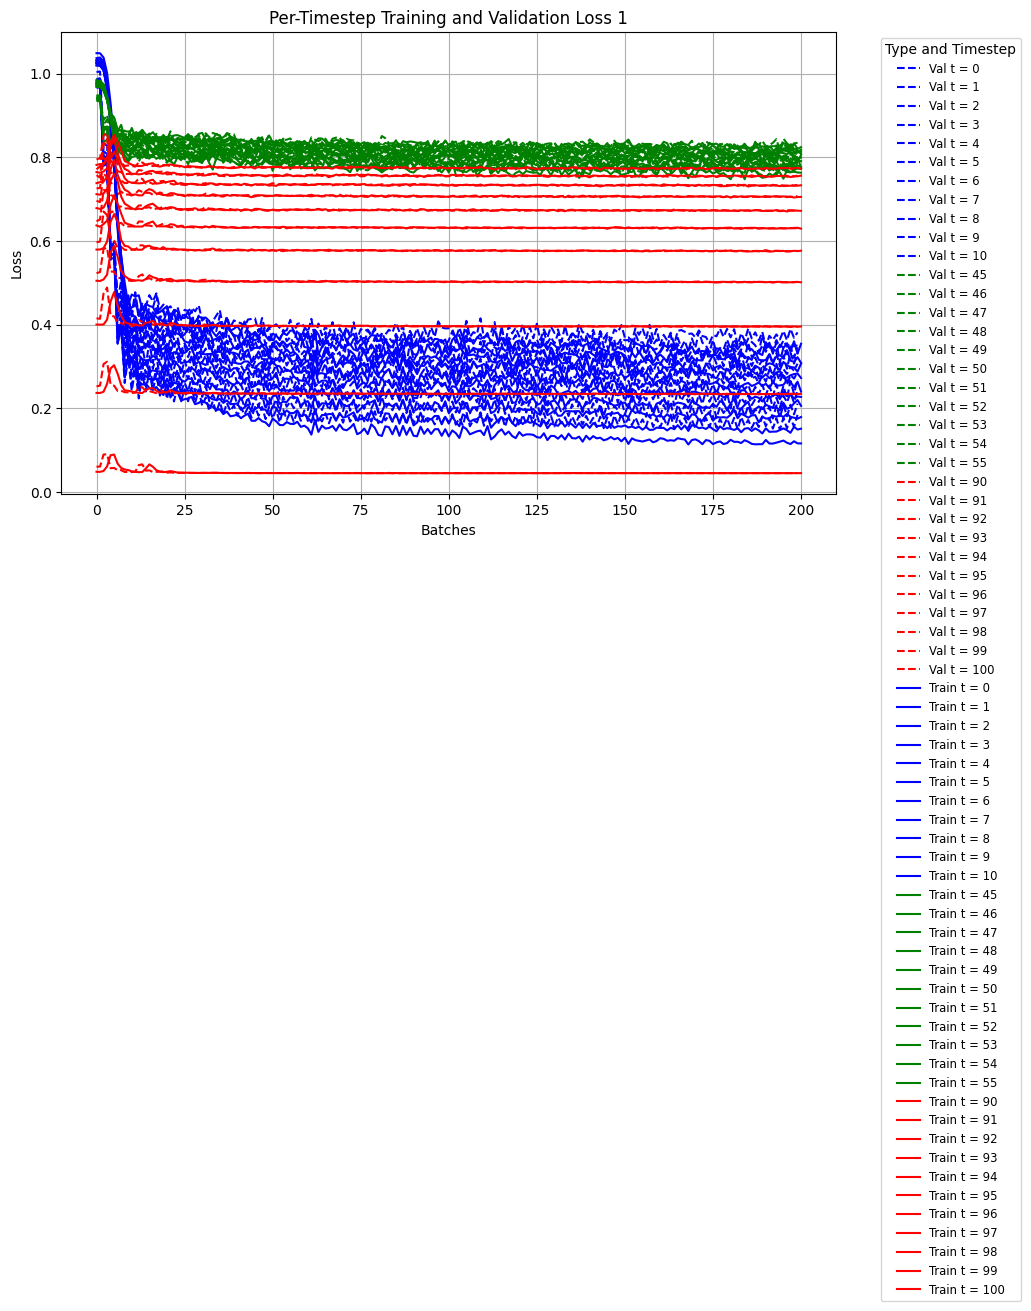

Generating a new digit...


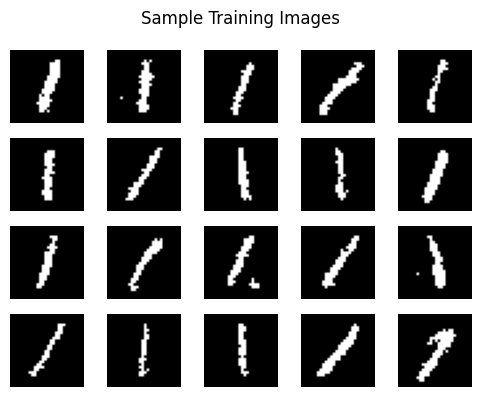

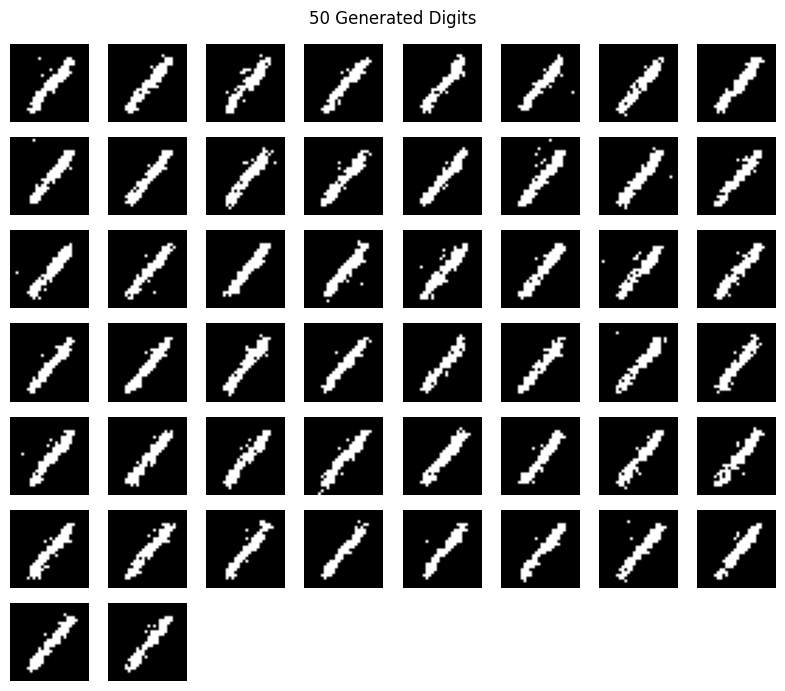

No trained diffusion model for 2 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72227.6484
Validation Loss: 70556.8008


Epoch: 1: Loss: 72015.2421875


Epoch: 2

Batch 0, Loss: 70512.6172
Validation Loss: 65756.5195


Epoch: 2: Loss: 69433.84375


Epoch: 3

Batch 0, Loss: 65455.7734
Validation Loss: 61273.7539


Epoch: 3: Loss: 64016.828125


Epoch: 4

Batch 0, Loss: 60850.0195
Validation Loss: 60195.1973


Epoch: 4: Loss: 60337.8515625


Epoch: 5

Batch 0, Loss: 59785.6562
Validation Loss: 60277.8926


Epoch: 5: Loss: 59545.41796875


Epoch: 6

Batch 0, Loss: 59256.8008
Validation Loss: 59659.4941


Epoch: 6: Loss: 59215.25


Epoch: 7

Batch 0, Loss: 57969.4688
Validation Loss: 59142.5488


Epoch: 7: Loss: 58728.265625


Epoch: 8

Batch 0, Loss: 58674.0703
Validation Loss: 59178.3418


Epoch: 8: Loss: 58469.2421875


Epoch: 9

Batch 0, Loss: 58882.6367
Validation Loss: 59082.1797


Epoch: 9: Loss: 58565.6171875


Epoch: 10

Batch 0, Loss: 58540.4453
Validation Loss: 59036.4

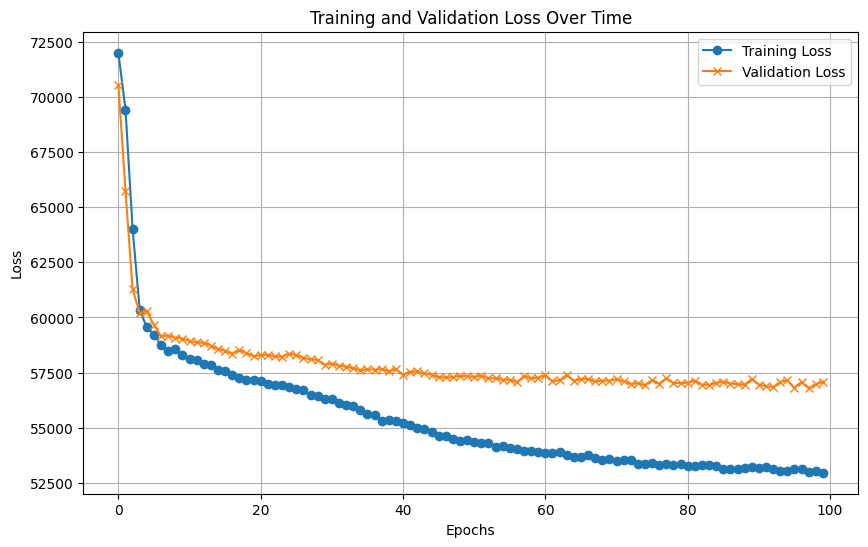

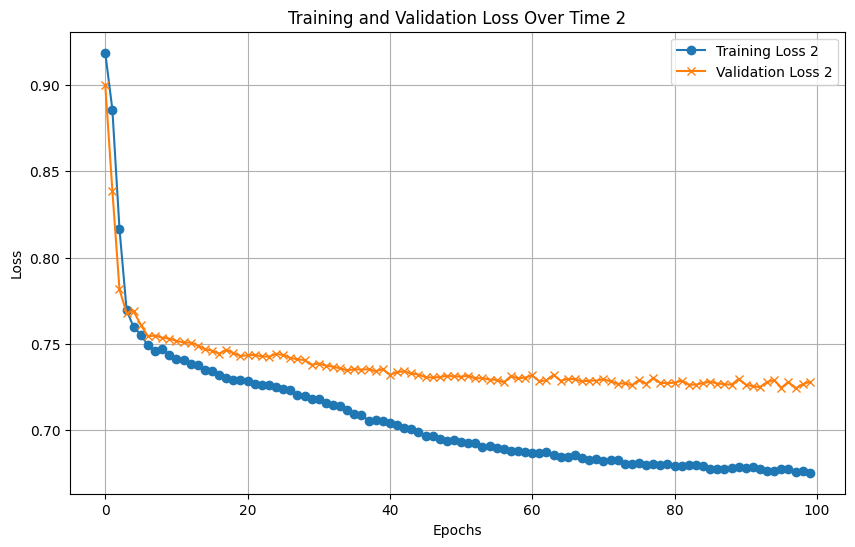

<Figure size 800x500 with 0 Axes>

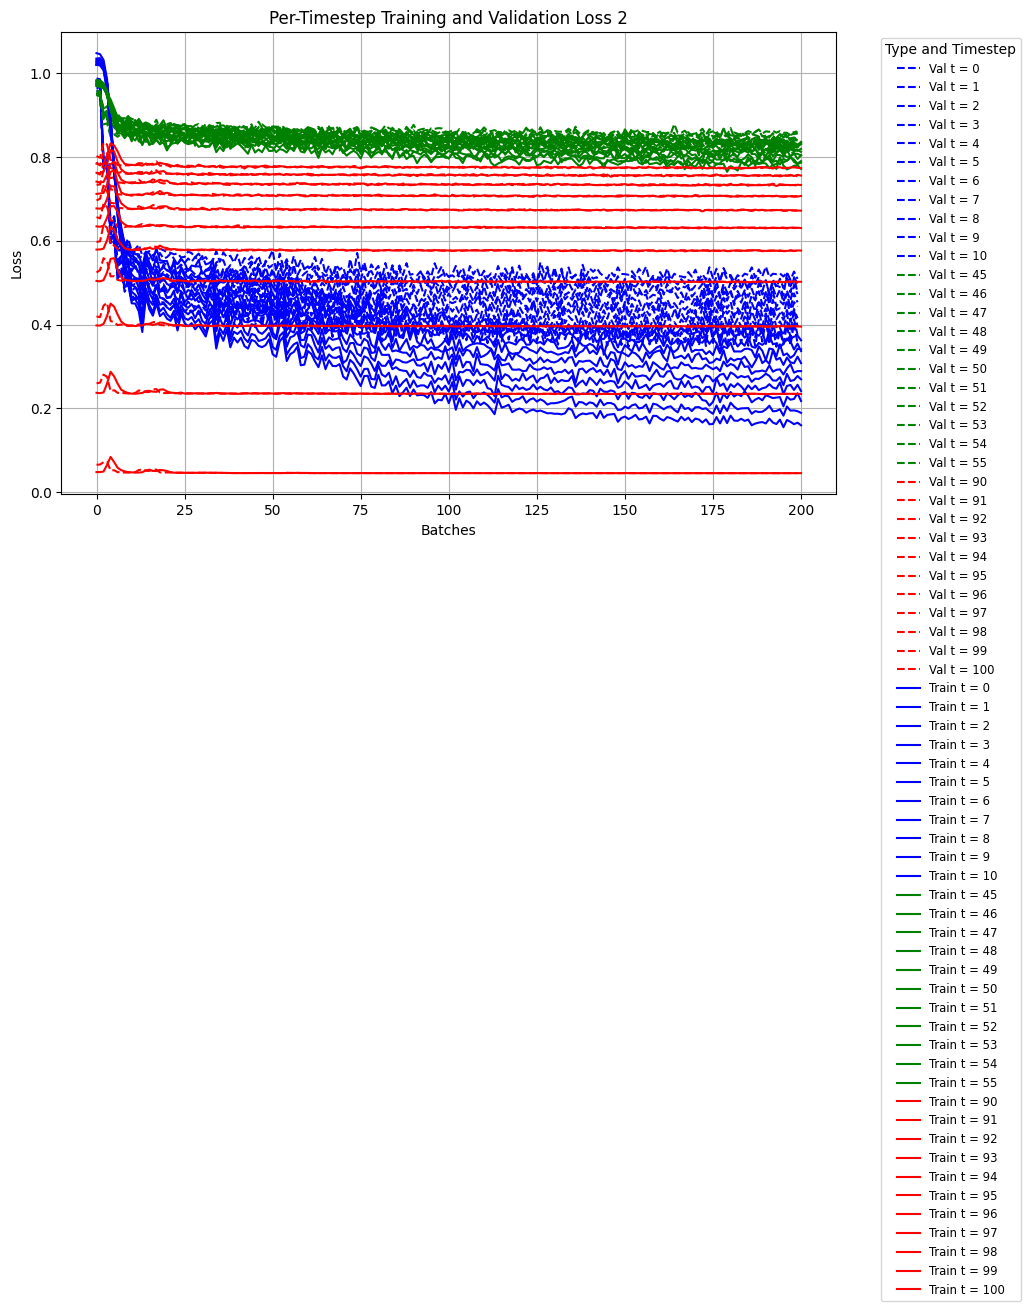

Generating a new digit...


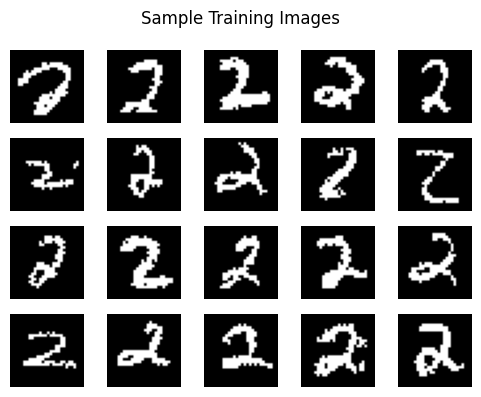

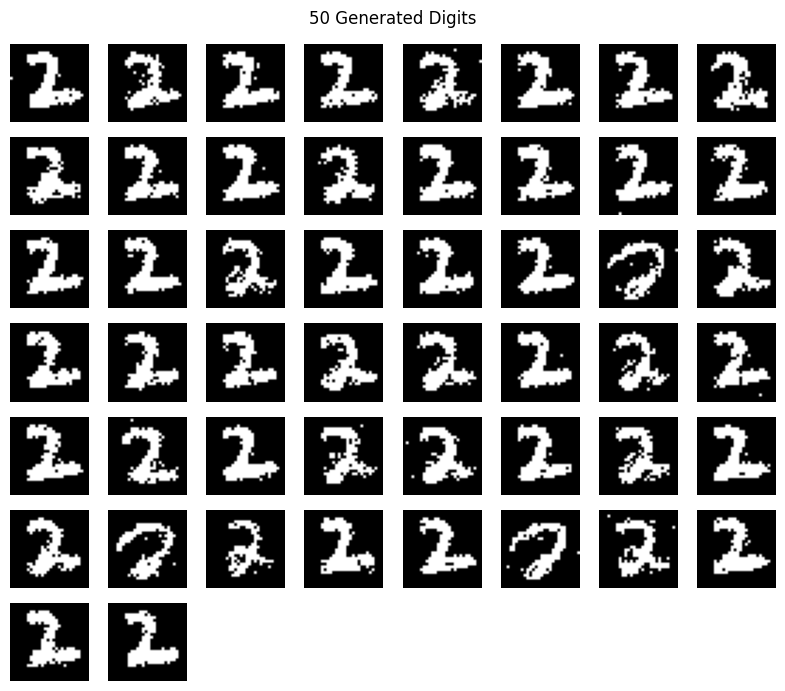

No trained diffusion model for 3 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72225.8984
Validation Loss: 70908.1953


Epoch: 1: Loss: 72066.25


Epoch: 2

Batch 0, Loss: 70860.5469
Validation Loss: 66776.5977


Epoch: 2: Loss: 69864.515625


Epoch: 3

Batch 0, Loss: 66349.8906
Validation Loss: 62385.6426


Epoch: 3: Loss: 64894.546875


Epoch: 4

Batch 0, Loss: 60612.2695
Validation Loss: 59677.4199


Epoch: 4: Loss: 60197.31640625


Epoch: 5

Batch 0, Loss: 57878.1797
Validation Loss: 59124.5469


Epoch: 5: Loss: 57695.9453125


Epoch: 6

Batch 0, Loss: 57147.8008
Validation Loss: 58940.0312


Epoch: 6: Loss: 57314.6328125


Epoch: 7

Batch 0, Loss: 57154.8047
Validation Loss: 58875.0254


Epoch: 7: Loss: 57265.375


Epoch: 8

Batch 0, Loss: 56956.2266
Validation Loss: 58476.0020


Epoch: 8: Loss: 56953.5703125


Epoch: 9

Batch 0, Loss: 56956.9609
Validation Loss: 58517.2871


Epoch: 9: Loss: 56877.8046875


Epoch: 10

Batch 0, Loss: 57045.4492
Validation Loss: 58584.712

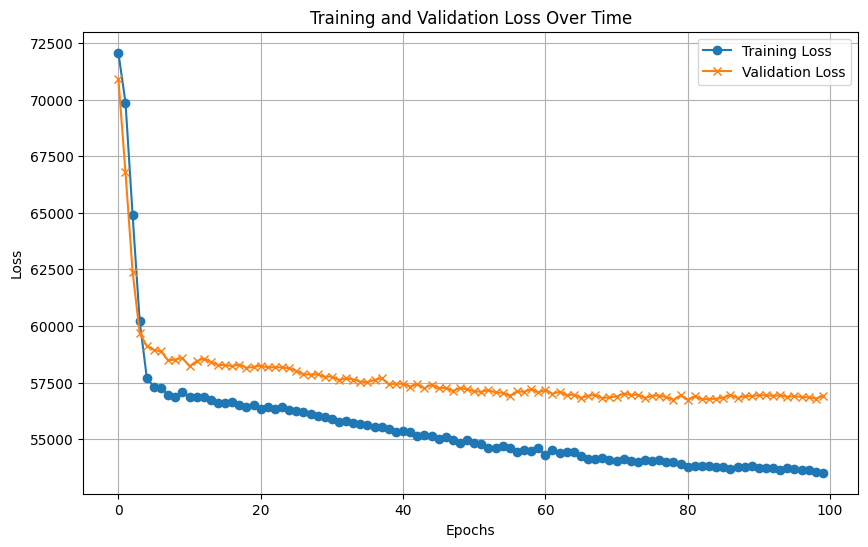

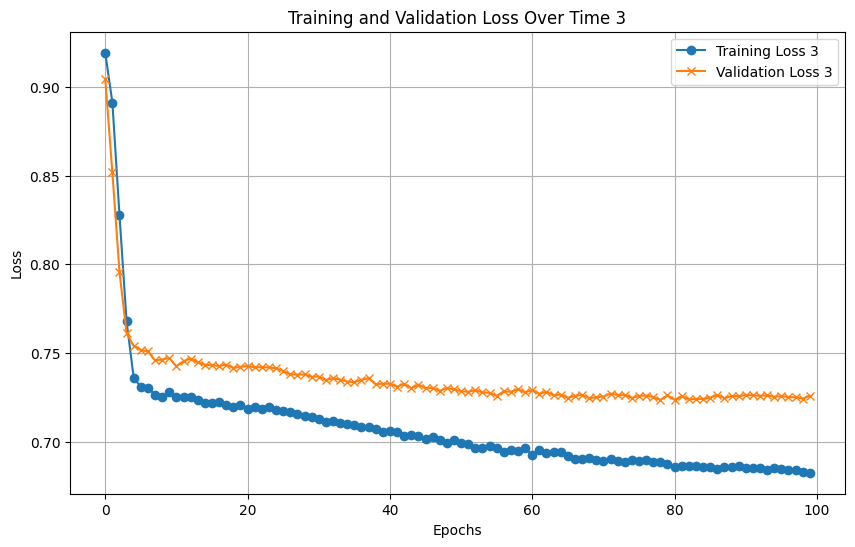

<Figure size 800x500 with 0 Axes>

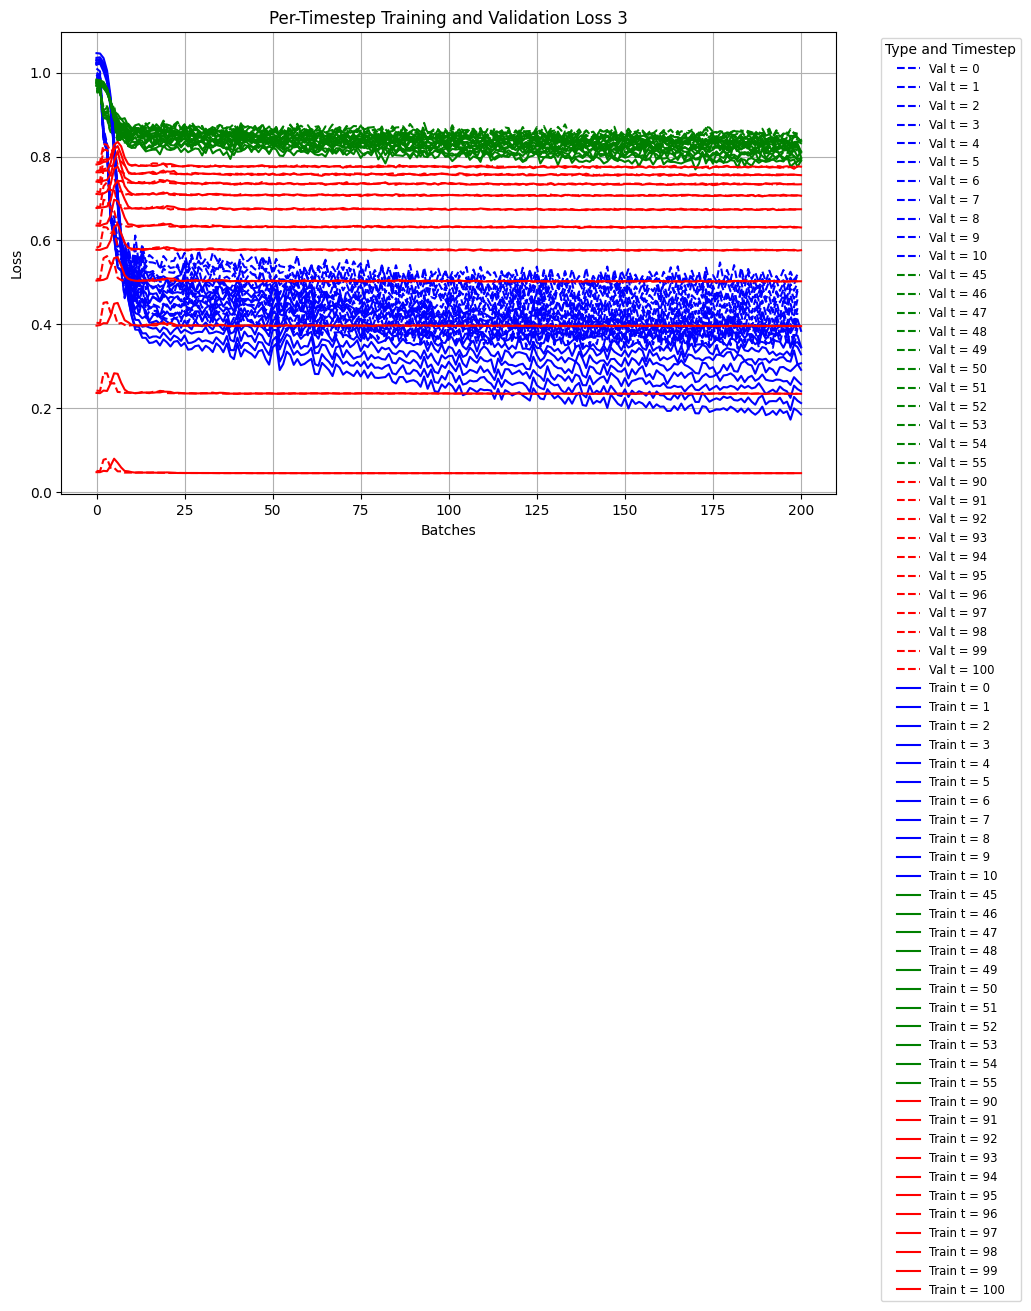

Generating a new digit...


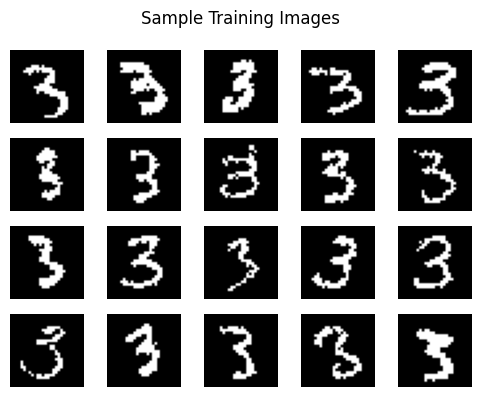

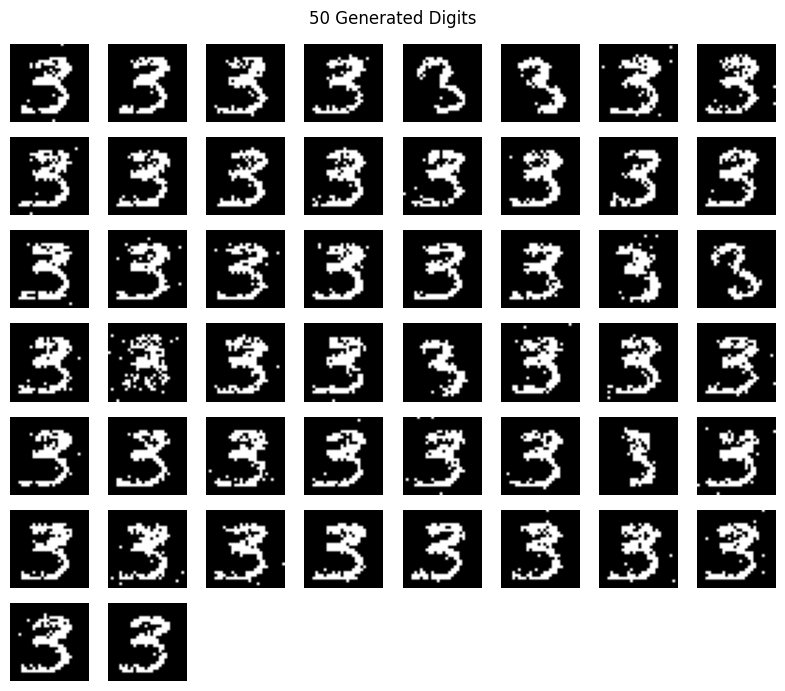

No trained diffusion model for 4 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72232.6406
Validation Loss: 70104.6016


Epoch: 1: Loss: 72054.0078125


Epoch: 2

Batch 0, Loss: 70099.1250
Validation Loss: 64801.2598


Epoch: 2: Loss: 68765.828125


Epoch: 3

Batch 0, Loss: 64537.2695
Validation Loss: 59809.0938


Epoch: 3: Loss: 63022.1171875


Epoch: 4

Batch 0, Loss: 58916.7734
Validation Loss: 58349.3945


Epoch: 4: Loss: 58606.40625


Epoch: 5

Batch 0, Loss: 57236.4688
Validation Loss: 58285.8145


Epoch: 5: Loss: 57684.734375


Epoch: 6

Batch 0, Loss: 56225.8438
Validation Loss: 57834.0820


Epoch: 6: Loss: 57317.16015625


Epoch: 7

Batch 0, Loss: 57286.4609
Validation Loss: 57621.1992


Epoch: 7: Loss: 56954.5703125


Epoch: 8

Batch 0, Loss: 56695.1055
Validation Loss: 57549.2617


Epoch: 8: Loss: 56851.2734375


Epoch: 9

Batch 0, Loss: 56815.3750
Validation Loss: 57525.0625


Epoch: 9: Loss: 56746.58203125


Epoch: 10

Batch 0, Loss: 56845.8984
Validation Loss: 5

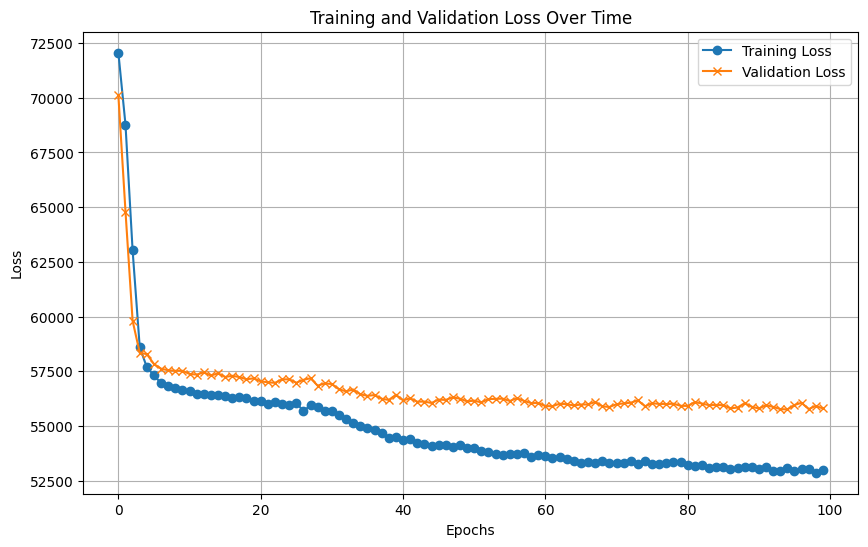

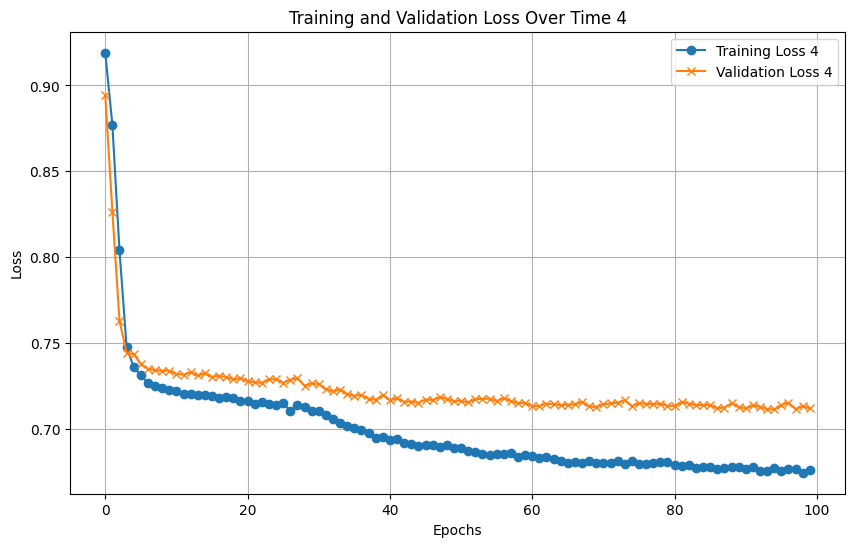

<Figure size 800x500 with 0 Axes>

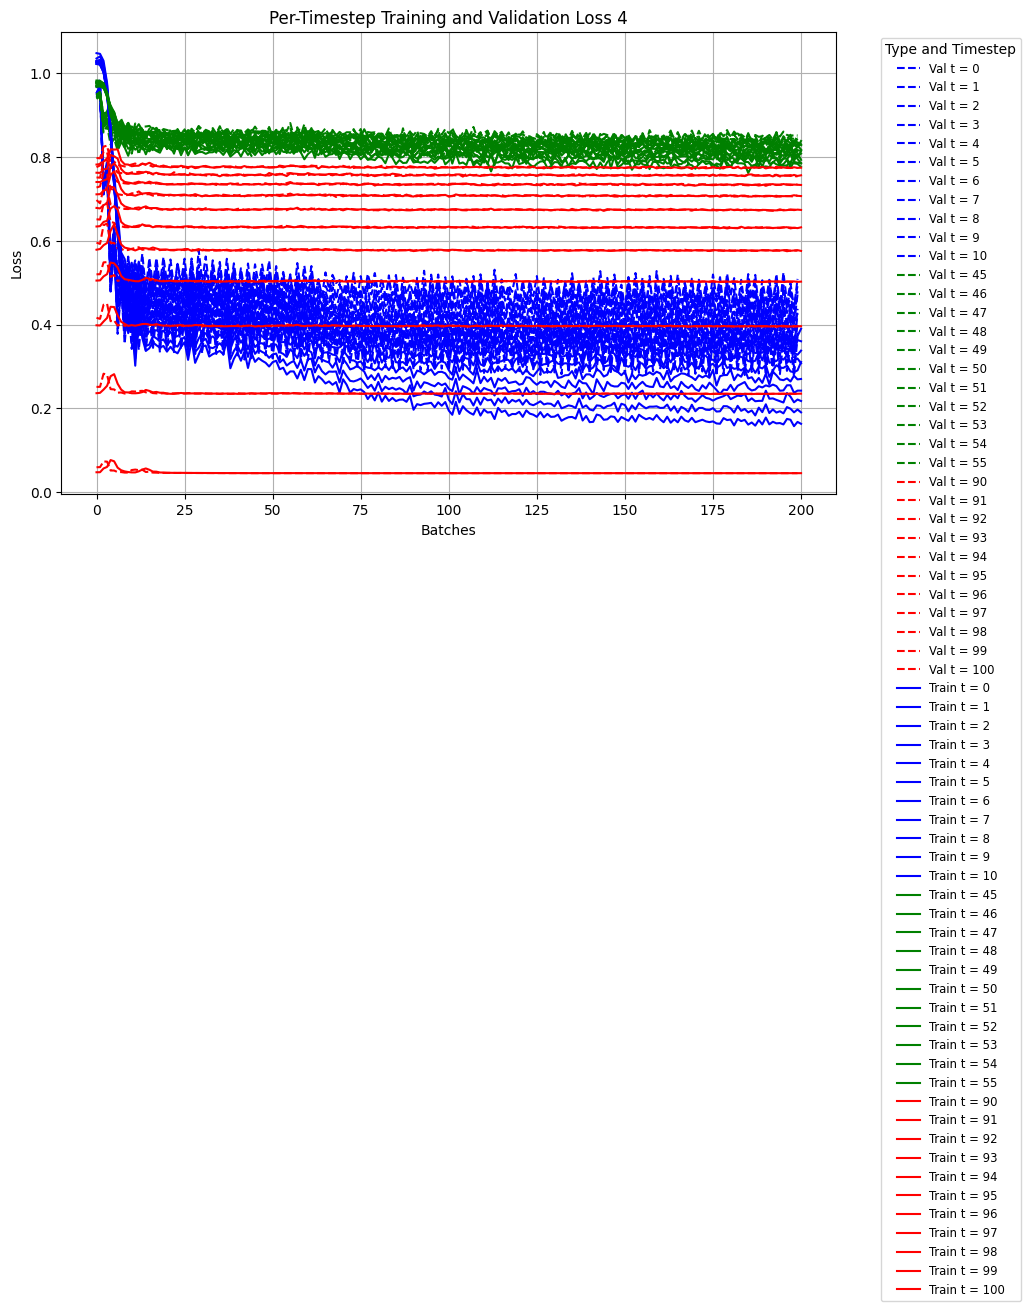

Generating a new digit...


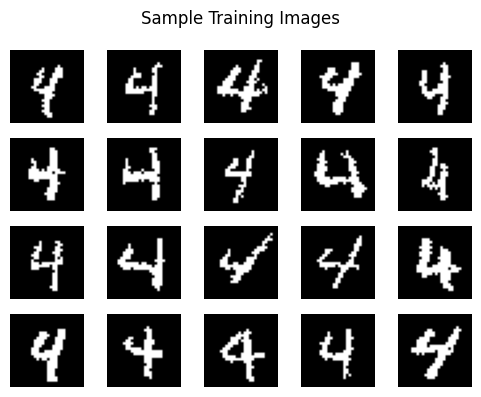

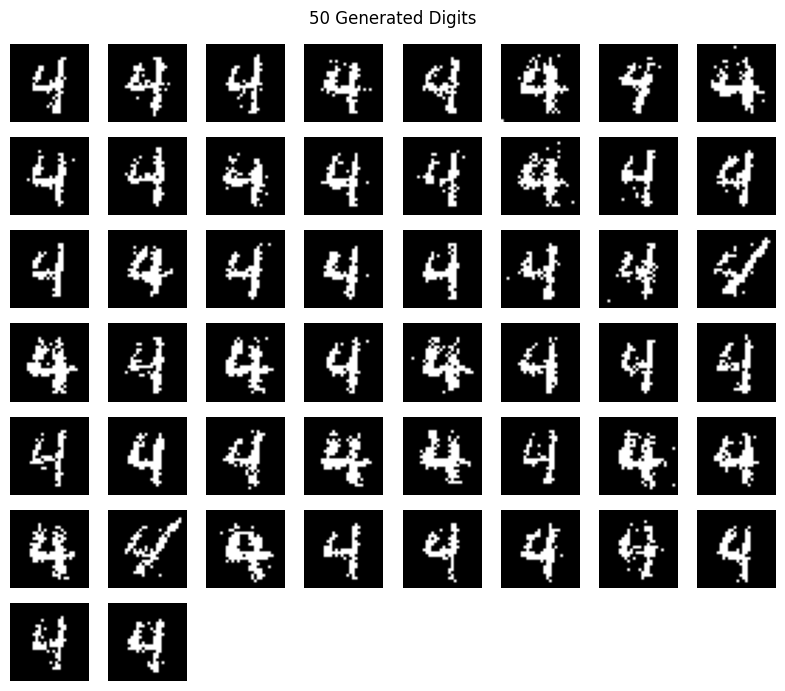

No trained diffusion model for 5 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72231.8438
Validation Loss: 70902.1250


Epoch: 1: Loss: 72056.125


Epoch: 2

Batch 0, Loss: 70758.9141
Validation Loss: 66769.3047


Epoch: 2: Loss: 69628.75


Epoch: 3

Batch 0, Loss: 66073.9062
Validation Loss: 62760.0938


Epoch: 3: Loss: 64517.875


Epoch: 4

Batch 0, Loss: 60733.2070
Validation Loss: 61222.0039


Epoch: 4: Loss: 60188.6484375


Epoch: 5

Batch 0, Loss: 58782.3516
Validation Loss: 60783.8652


Epoch: 5: Loss: 58590.84375


Epoch: 6

Batch 0, Loss: 58855.6992
Validation Loss: 60672.0371


Epoch: 6: Loss: 58222.3359375


Epoch: 7

Batch 0, Loss: 58147.0117
Validation Loss: 60719.6777


Epoch: 7: Loss: 58038.703125


Epoch: 8

Batch 0, Loss: 58056.9258
Validation Loss: 60443.2773


Epoch: 8: Loss: 58046.22265625


Epoch: 9

Batch 0, Loss: 57924.6992
Validation Loss: 60755.6484


Epoch: 9: Loss: 58151.4296875


Epoch: 10

Batch 0, Loss: 57836.3008
Validation Loss: 60482.1367


E

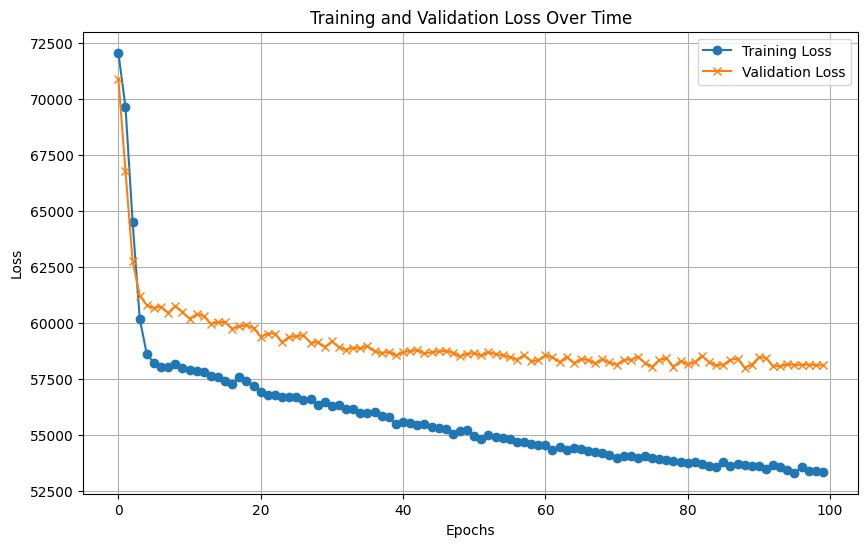

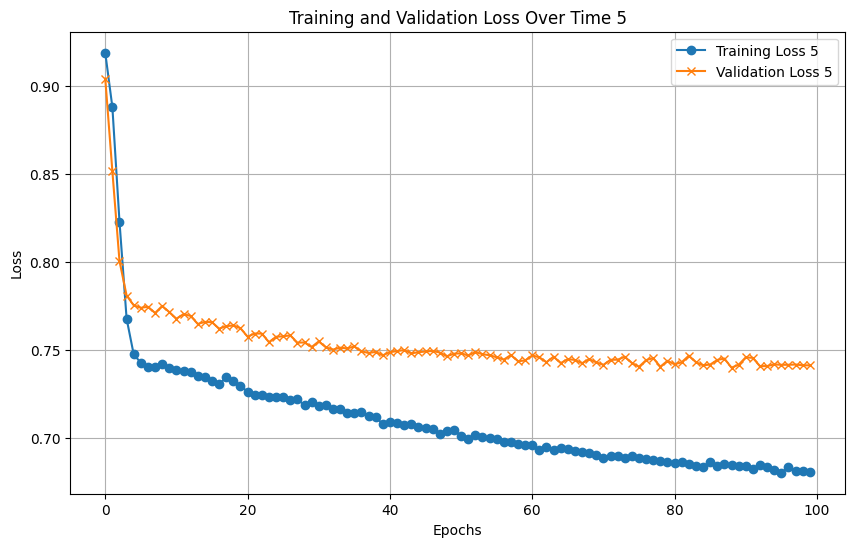

<Figure size 800x500 with 0 Axes>

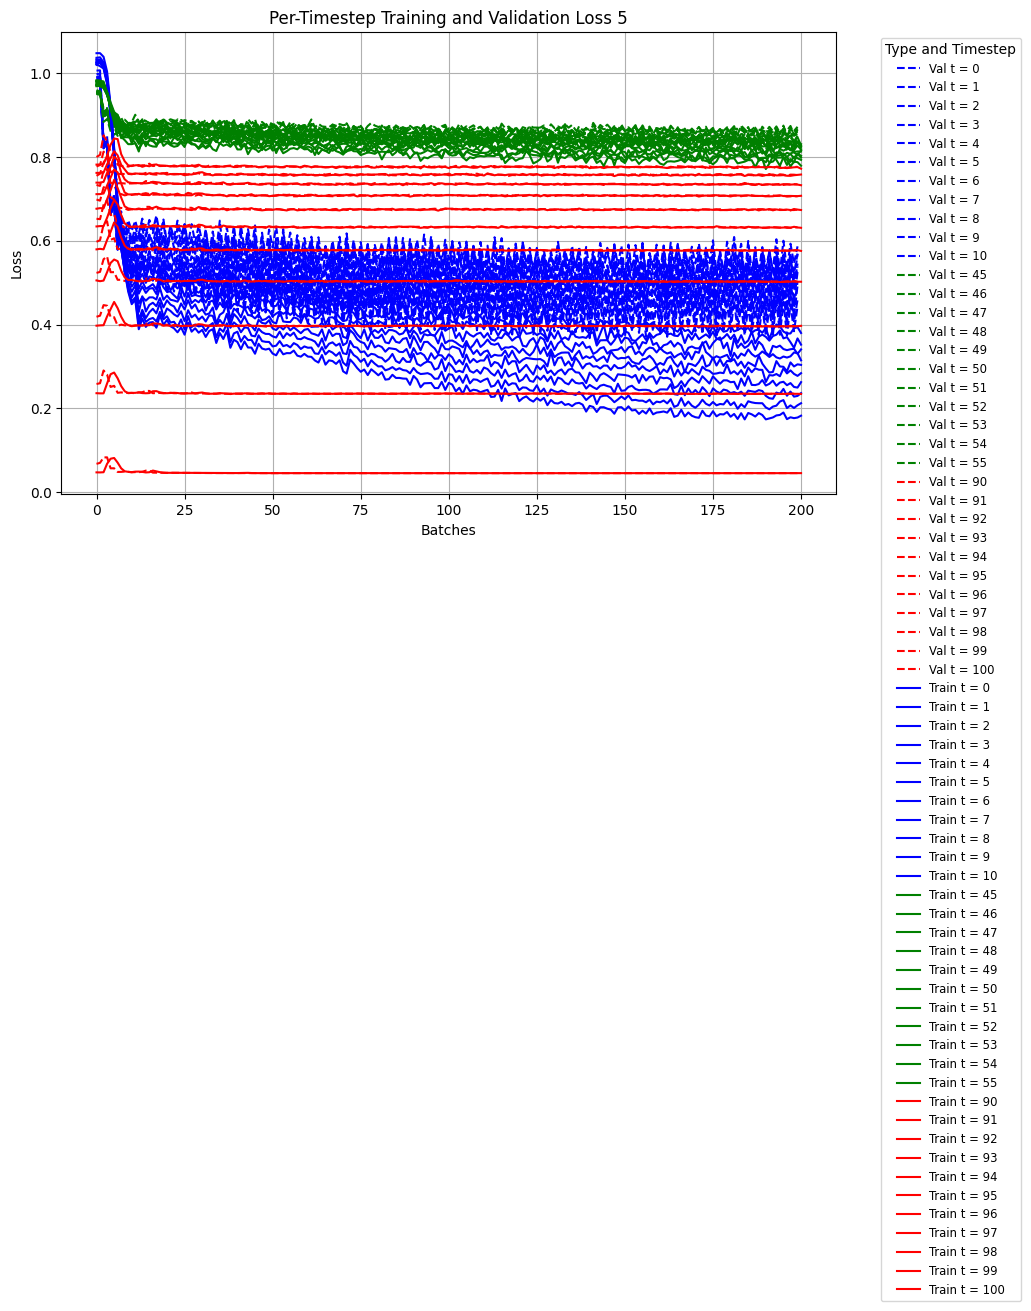

Generating a new digit...


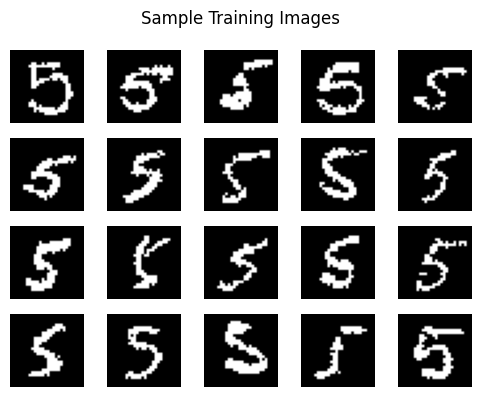

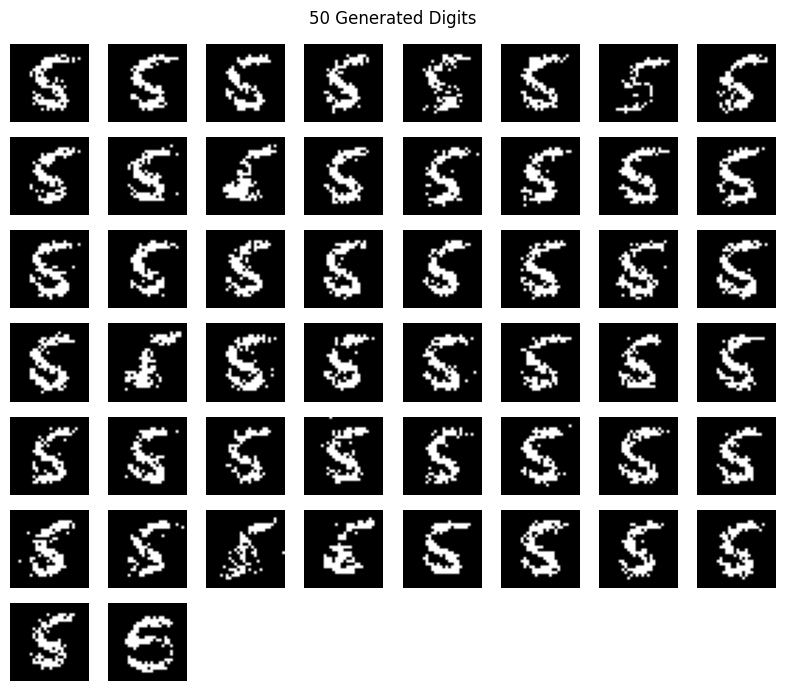

No trained diffusion model for 6 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72219.4531
Validation Loss: 70744.0977


Epoch: 1: Loss: 72053.78125


Epoch: 2

Batch 0, Loss: 70680.0391
Validation Loss: 65441.8867


Epoch: 2: Loss: 69351.28125


Epoch: 3

Batch 0, Loss: 65451.0234
Validation Loss: 60473.5859


Epoch: 3: Loss: 63620.125


Epoch: 4

Batch 0, Loss: 60136.7891
Validation Loss: 58909.8926


Epoch: 4: Loss: 59870.4609375


Epoch: 5

Batch 0, Loss: 57989.6953
Validation Loss: 58245.7891


Epoch: 5: Loss: 58485.6484375


Epoch: 6

Batch 0, Loss: 58904.2930
Validation Loss: 58310.4395


Epoch: 6: Loss: 58149.2578125


Epoch: 7

Batch 0, Loss: 58031.4297
Validation Loss: 58002.7266


Epoch: 7: Loss: 57770.9765625


Epoch: 8

Batch 0, Loss: 57646.5547
Validation Loss: 58131.9922


Epoch: 8: Loss: 57658.265625


Epoch: 9

Batch 0, Loss: 57432.4570
Validation Loss: 58020.4668


Epoch: 9: Loss: 57680.28515625


Epoch: 10

Batch 0, Loss: 57494.2070
Validation Loss: 57825.1

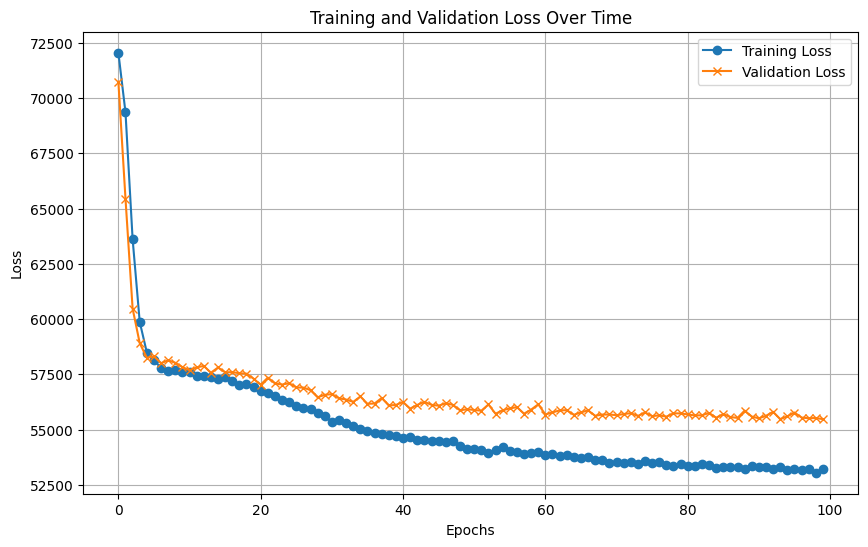

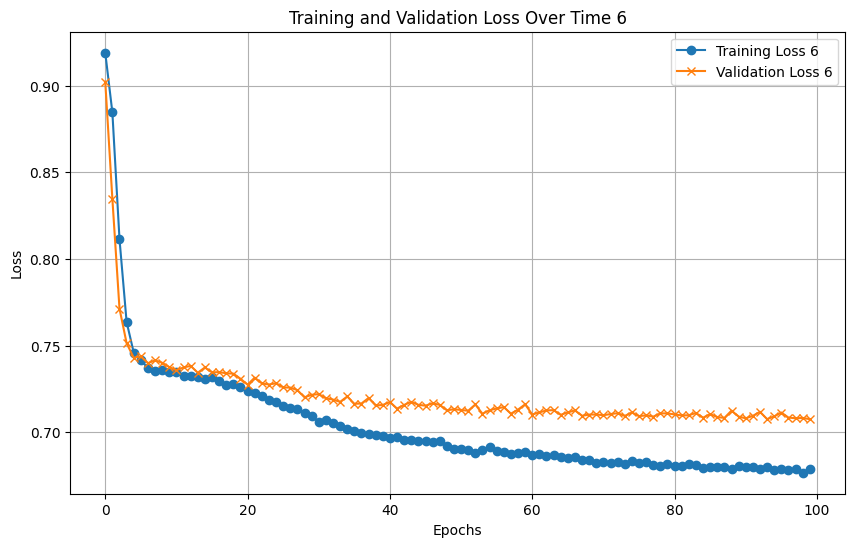

<Figure size 800x500 with 0 Axes>

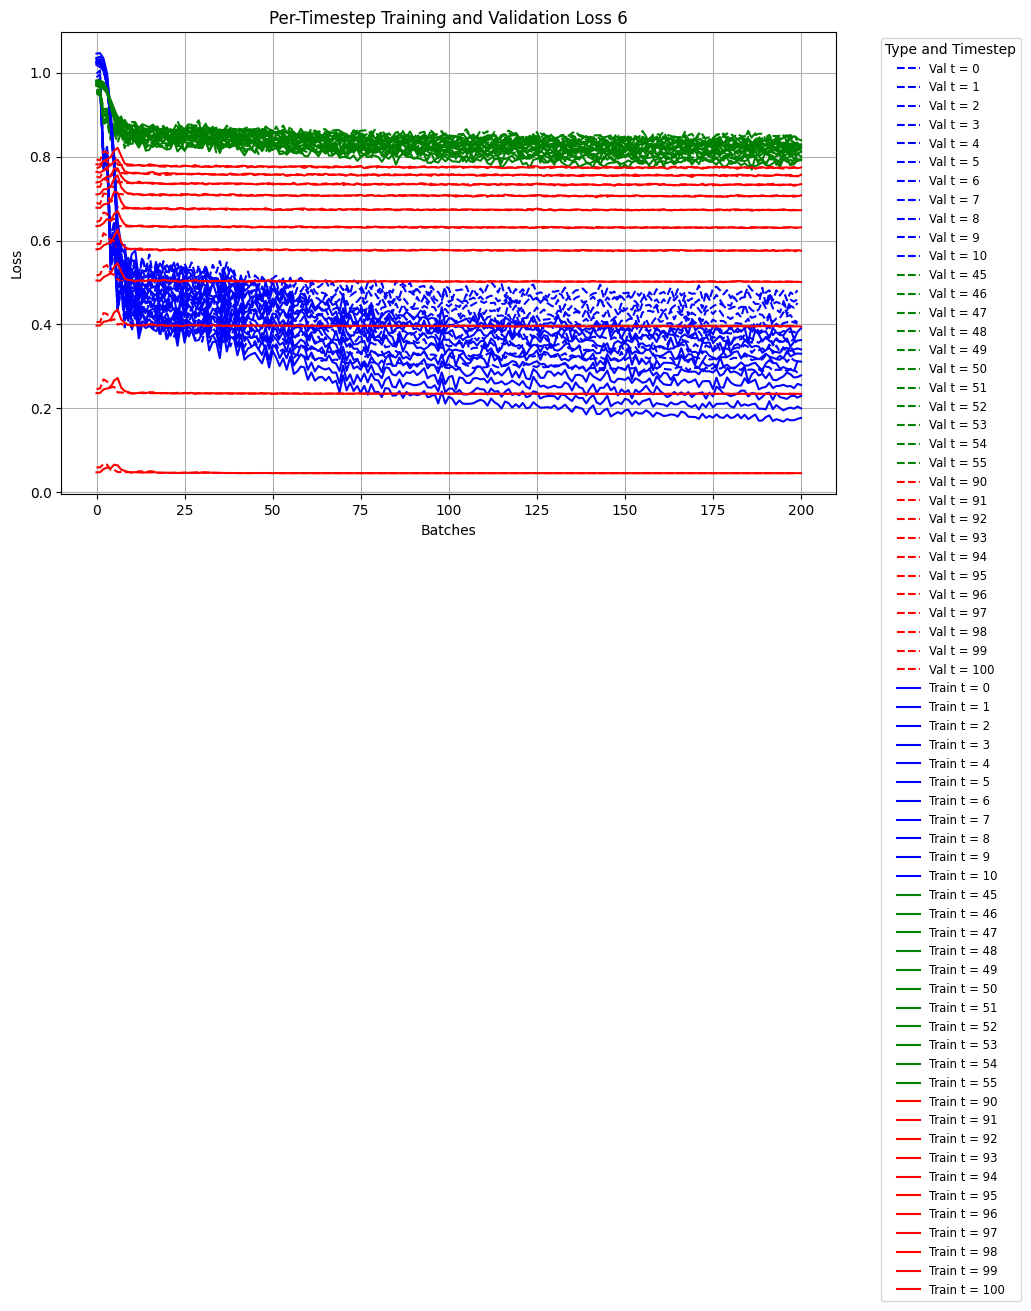

Generating a new digit...


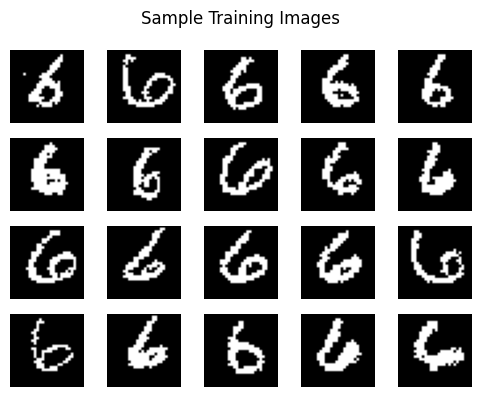

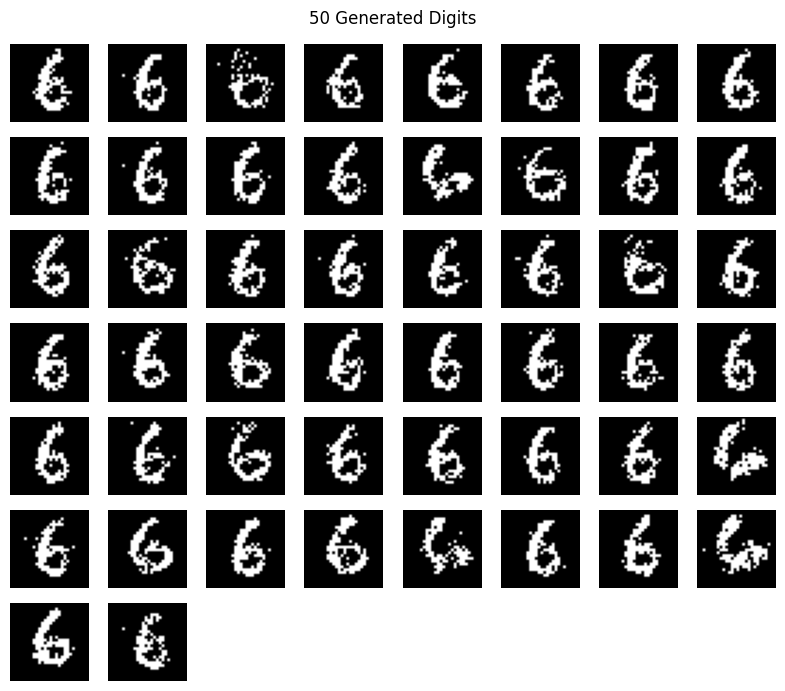

No trained diffusion model for 7 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72239.2031
Validation Loss: 70288.4844


Epoch: 1: Loss: 71986.1015625


Epoch: 2

Batch 0, Loss: 70211.7734
Validation Loss: 65083.7441


Epoch: 2: Loss: 68898.96875


Epoch: 3

Batch 0, Loss: 64418.7695
Validation Loss: 60000.8438


Epoch: 3: Loss: 63209.1484375


Epoch: 4

Batch 0, Loss: 59182.3125
Validation Loss: 58033.3145


Epoch: 4: Loss: 58758.12890625


Epoch: 5

Batch 0, Loss: 57707.5547
Validation Loss: 57627.1953


Epoch: 5: Loss: 57313.6484375


Epoch: 6

Batch 0, Loss: 56814.1953
Validation Loss: 57663.5605


Epoch: 6: Loss: 56935.34375


Epoch: 7

Batch 0, Loss: 57166.6328
Validation Loss: 57677.1074


Epoch: 7: Loss: 56868.890625


Epoch: 8

Batch 0, Loss: 56665.6641
Validation Loss: 57671.3652


Epoch: 8: Loss: 56661.96875


Epoch: 9

Batch 0, Loss: 57080.1016
Validation Loss: 57478.5078


Epoch: 9: Loss: 56669.9375


Epoch: 10

Batch 0, Loss: 56319.2109
Validation Loss: 57496.75

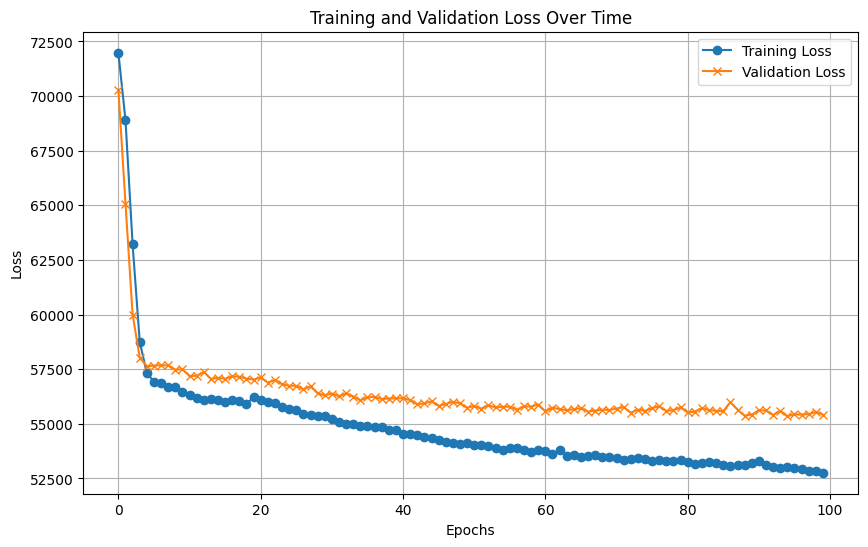

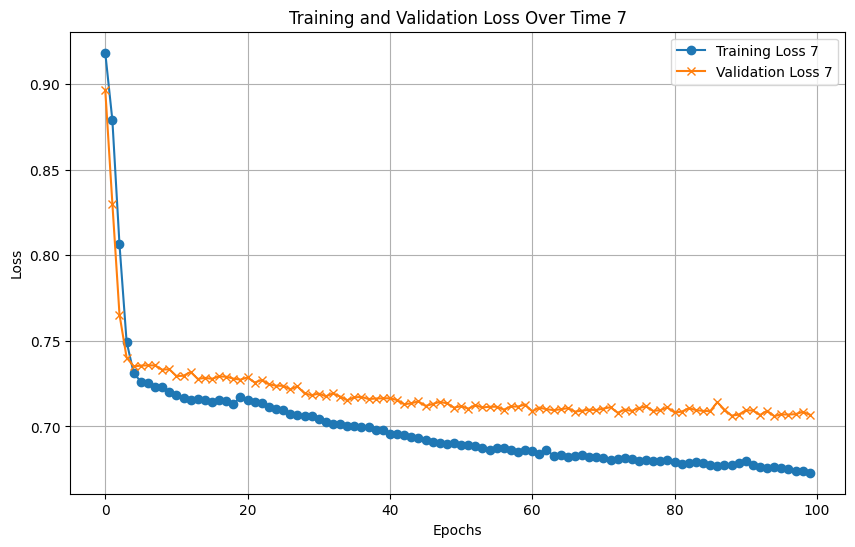

<Figure size 800x500 with 0 Axes>

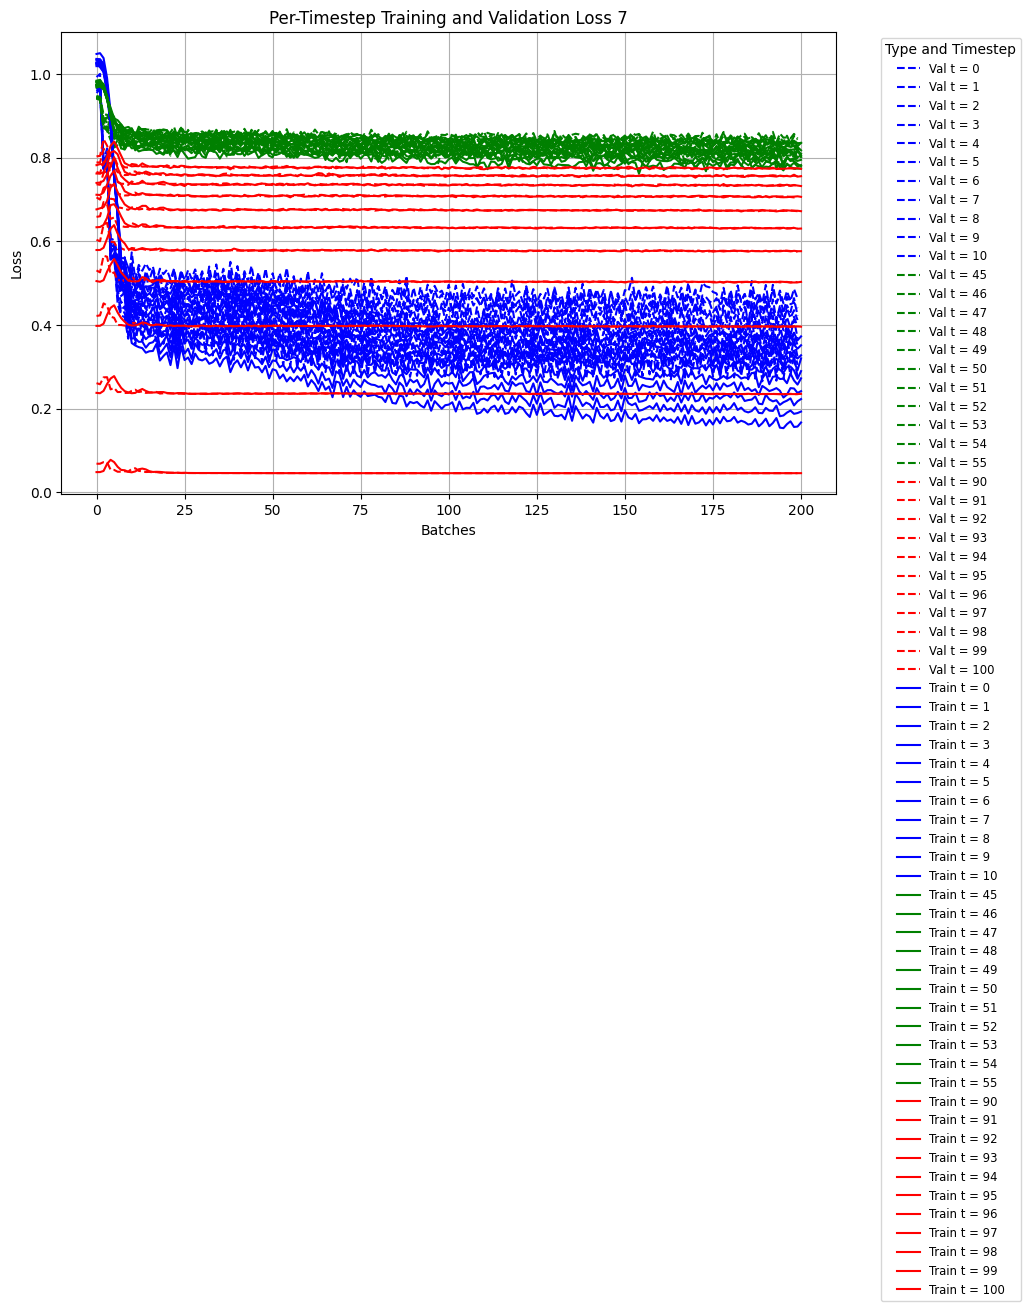

Generating a new digit...


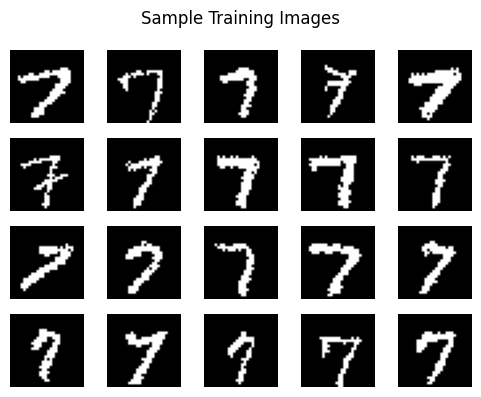

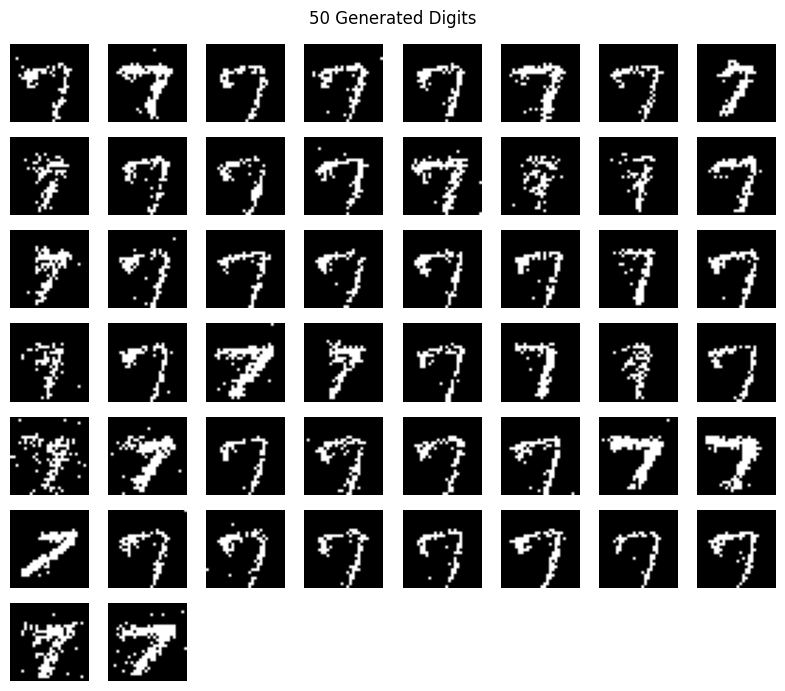

No trained diffusion model for 8 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72225.8125
Validation Loss: 70560.1562


Epoch: 1: Loss: 71998.6171875


Epoch: 2

Batch 0, Loss: 70472.3906
Validation Loss: 65746.7070


Epoch: 2: Loss: 69427.0078125


Epoch: 3

Batch 0, Loss: 65678.7109
Validation Loss: 61127.6055


Epoch: 3: Loss: 64623.5703125


Epoch: 4

Batch 0, Loss: 62017.3867
Validation Loss: 59054.1250


Epoch: 4: Loss: 60758.890625


Epoch: 5

Batch 0, Loss: 59201.2812
Validation Loss: 58654.0195


Epoch: 5: Loss: 59548.3203125


Epoch: 6

Batch 0, Loss: 58924.2734
Validation Loss: 58605.9961


Epoch: 6: Loss: 58912.125


Epoch: 7

Batch 0, Loss: 58785.8867
Validation Loss: 58493.0059


Epoch: 7: Loss: 58963.4609375


Epoch: 8

Batch 0, Loss: 58634.7109
Validation Loss: 58736.2344


Epoch: 8: Loss: 58655.6796875


Epoch: 9

Batch 0, Loss: 58912.6797
Validation Loss: 58641.4863


Epoch: 9: Loss: 58678.9609375


Epoch: 10

Batch 0, Loss: 58401.4805
Validation Loss: 5850

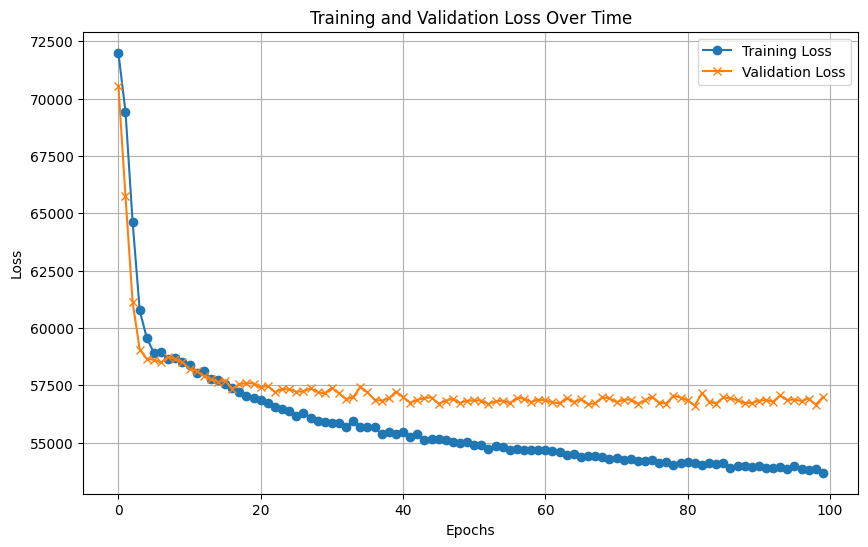

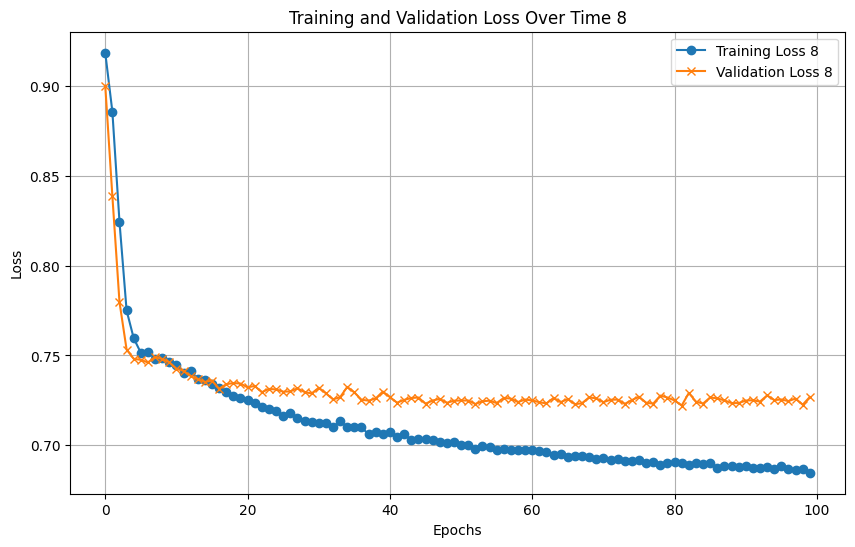

<Figure size 800x500 with 0 Axes>

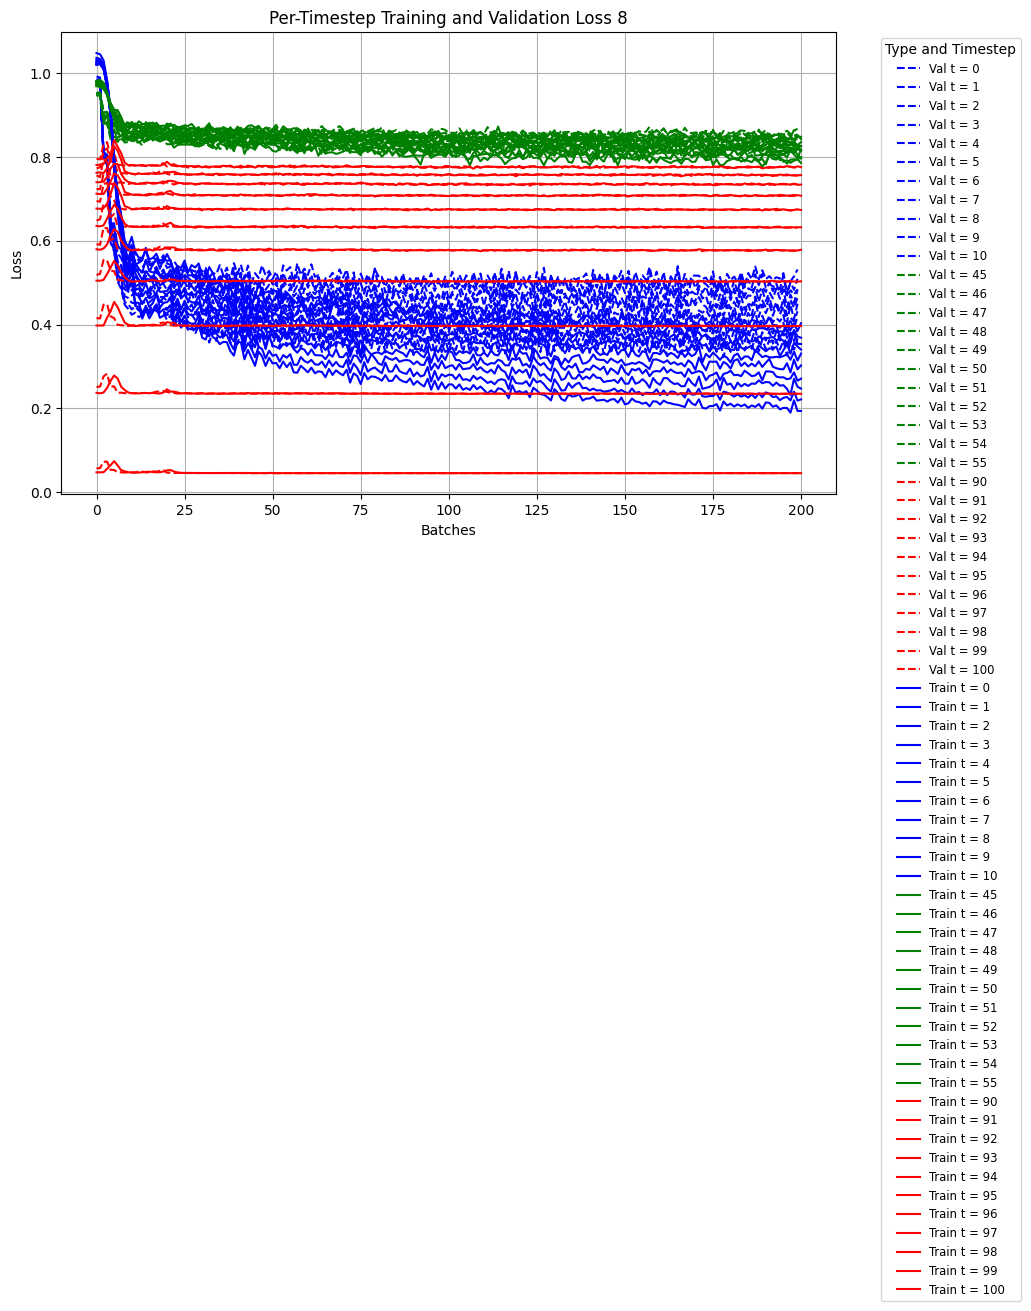

Generating a new digit...


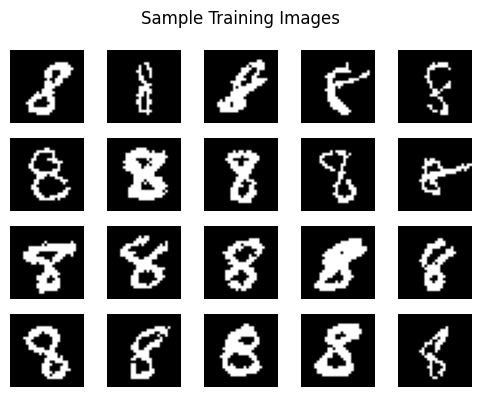

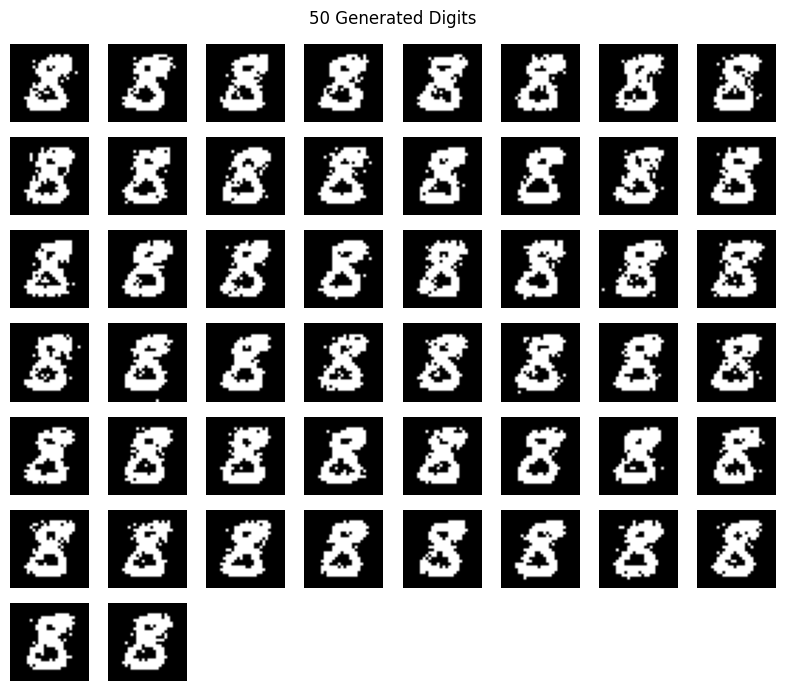

No trained diffusion model for 9 found. Training from scratch...
Epoch: 1

Batch 0, Loss: 72237.3828
Validation Loss: 70307.2695


Epoch: 1: Loss: 72031.90625


Epoch: 2

Batch 0, Loss: 70270.0234
Validation Loss: 65433.9219


Epoch: 2: Loss: 69027.984375


Epoch: 3

Batch 0, Loss: 65093.0820
Validation Loss: 60683.7500


Epoch: 3: Loss: 63720.0546875


Epoch: 4

Batch 0, Loss: 59838.0000
Validation Loss: 58551.1875


Epoch: 4: Loss: 59418.796875


Epoch: 5

Batch 0, Loss: 57854.6016
Validation Loss: 58541.2441


Epoch: 5: Loss: 57660.390625


Epoch: 6

Batch 0, Loss: 57976.8125
Validation Loss: 58199.5156


Epoch: 6: Loss: 57457.64453125


Epoch: 7

Batch 0, Loss: 57045.9375
Validation Loss: 57997.9082


Epoch: 7: Loss: 57152.421875


Epoch: 8

Batch 0, Loss: 57450.7578
Validation Loss: 57953.7520


Epoch: 8: Loss: 57153.171875


Epoch: 9

Batch 0, Loss: 56163.1562
Validation Loss: 58165.4531


Epoch: 9: Loss: 57001.1640625


Epoch: 10

Batch 0, Loss: 57383.8359
Validation Loss: 58113

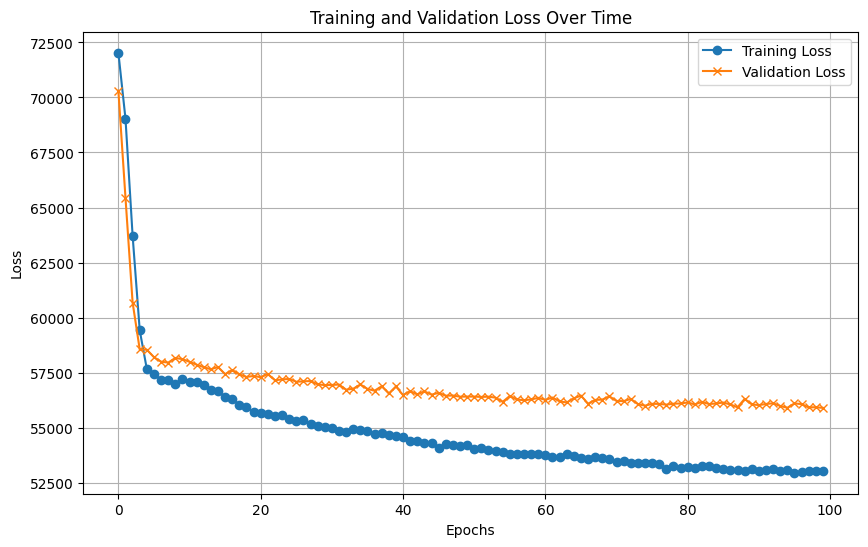

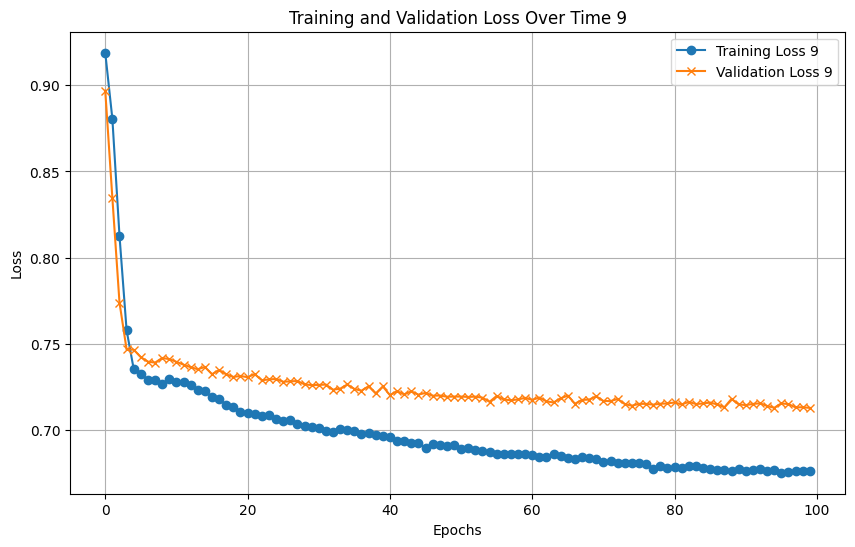

<Figure size 800x500 with 0 Axes>

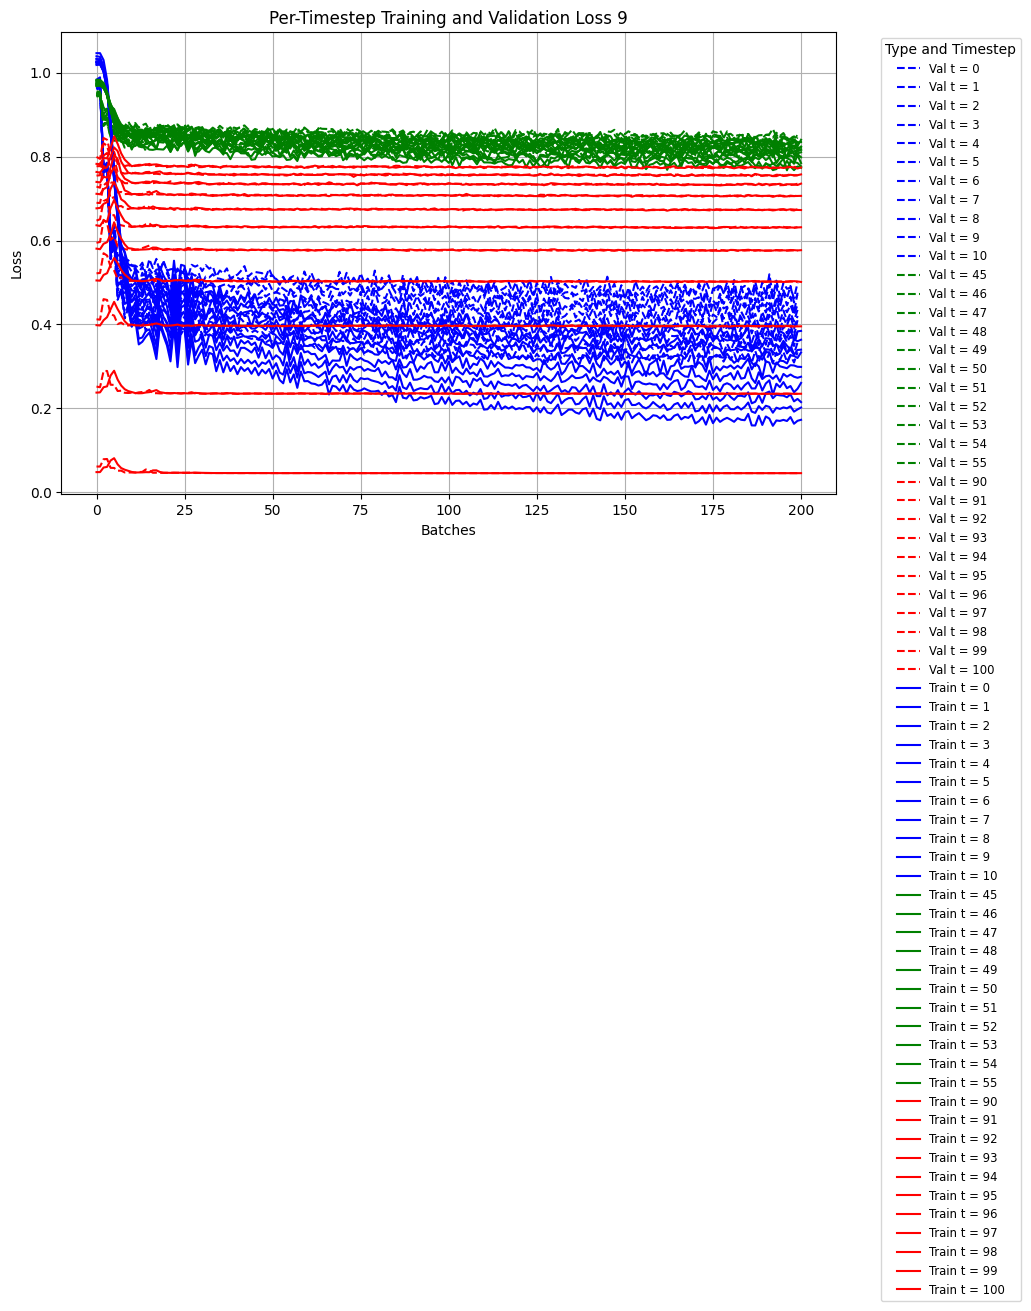

Generating a new digit...


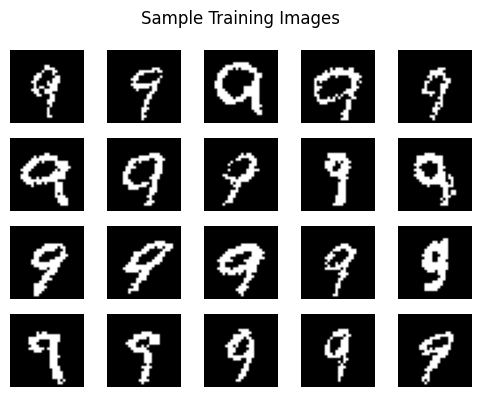

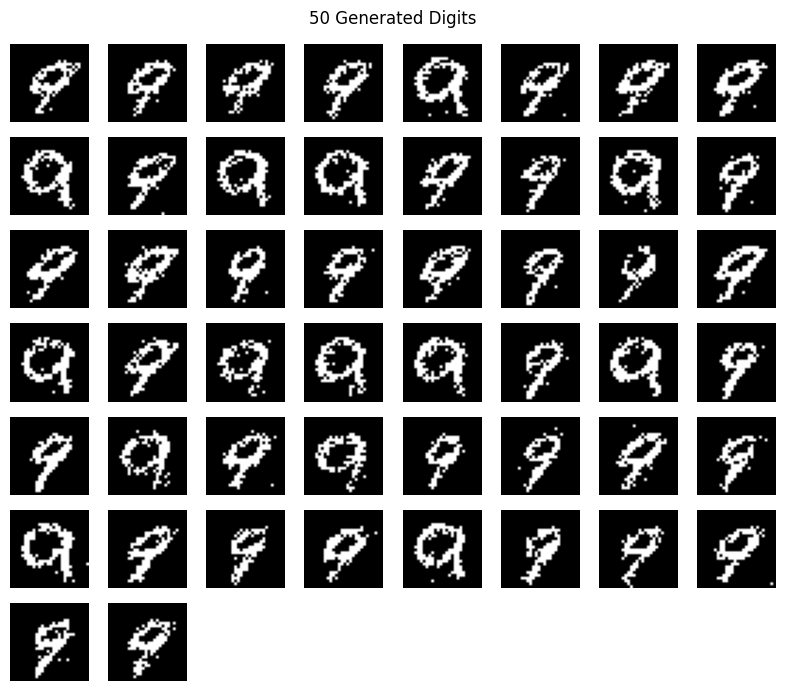

In [ ]:
if not os.path.exists(result_dir):
    print(f"Checkpoint directory '{result_dir}' does not exist.")

if not os.path.exists(latest_model_path):
    print(f"Checkpoint file '{latest_model_path}' does not exist.")

# while True:
#     try:
#         digit = int(input("Enter a digit (0–9): "))
#         if 0 <= digit <= 9:
#             break
#         else:
#             print("Please enter a number between 0 and 9.")
#     except ValueError:
#         print("Invalid input. Please enter a number.")

train_loaders = {}
val_loaders = {}

for i in range(0,10):
    digit = i
    model_path = f"model_{digit}.pth"
    latest_model_path = os.path.join(checkpoint_dir, model_path)

    model = BernoulliDiffusionModel()

    train_loss_tracking, val_loss_tracking = loss_tracking()

    train_loader, val_loader = get_train_data(digit)
    train_loaders[digit] = train_loader
    val_loaders[digit] = val_loader

    if os.path.exists(latest_model_path):
        print(f"Loading trained diffusion model for {digit}...")
        model.load_state_dict(torch.load(latest_model_path, map_location=device))
        model.eval()
    else:
        print(f"No trained diffusion model for {digit} found. Training from scratch...")
        #show_training_images(train_loader)
        trainer = Trainer(model, train_loader, val_loader)
        trainer.train()

    # Generate a new digit using the trained model
    print("Generating a new digit...")
    show_training_images(train_loaders[digit])
    plt.close()

    rows = int(num_examples ** 0.5)
    cols = int((num_examples + rows - 1) // rows)  # ensures enough columns
    plt.figure(figsize=(cols, rows))
    for i in range(num_examples):
        sampled_digit = model.p_sample(1).squeeze(0)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(sampled_digit.view(28, 28).cpu().numpy(), cmap='gray')
        plt.axis("off")
    plt.suptitle(f"{num_examples} Generated Digits")
    plt.tight_layout()

    path = os.path.join(result_dir, f'results_{digit}')

    os.makedirs(path, exist_ok=True)  # Make sure directory exists
    save_path = os.path.join(path, f"gen_{digit}.png")
    plt.savefig(save_path)

    plt.show()
    plt.close()